In [255]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

RANDOM_STATE = 42
TARGET = 'price'

cwd = os.getcwd()
print("Current working directory:", cwd)

file_name = os.path.join(cwd, '..', 'data', 'raw', 'casas_dev.csv')

df = pd.read_csv(file_name)

import sys
sys.path.append(os.path.join(cwd, '..', 'src'))
from utils import convert_sqft_to_m2, plot_pairplot, feature_engineer, get_city
from data_splitting import train_validate_split, cross_validate, k_fold_split
from models import LinearRegression
from metrics import Metrics, MSE, MAE, R2, RMSE
from preprocessing import one_hot_encoding, handle_missing_values, normalize_df

Current working directory: c:\Users\iluno\OneDrive\Documents\GitHub\ML\TP1\Nomberg_Ilan_TP1\notebooks


# 1.1 - Exploración y Limpieza de los Datos

Para comenzar con el análisis, exploramos una muestra aleatoria del dataset de desarrollo. En esta instancia identificamos algunas columnas con posibles problemas de calidad de datos:

- **Columna `age`**: Contiene valores faltantes (NaN), que pueden deberse a propiedades sin fecha de construcción registrada.
- **Columna `rooms`**: También presenta valores faltantes, probablemente por errores en la recolección de datos.
- **Columna `area_units`**: Utiliza etiquetas categóricas (por ejemplo, 'sqft' y 'm2'), lo cual puede dificultar su uso directo en modelos numéricos.
- **Columna `area`**: Está expresada en distintas unidades de medida, lo cual requiere ser unificado antes de cualquier análisis o modelado.

Con base en estas observaciones, realizamos las siguientes modificaciones:

1. **Manejo de Valores Faltantes**:
   - Aplicamos la función `handle_missing_values()` para imputar los valores ausentes.
   - En este caso, se utilizó la media de las columnas `age` y `rooms` dentro del conjunto de entrenamiento.

2. **Codificación Categórica**:
   - Aplicamos `one-hot encoding` sobre `area_units` para poder tratarla como variable numérica.

3. **Conversión de Unidades**:
   - Convertimos todas las áreas que estaban expresadas en `sqft` a `m2`, asegurando homogeneidad en la unidad de medida utilizada.

Estas transformaciones son fundamentales para garantizar la calidad y consistencia de los datos antes del entrenamiento de modelos.

# 1.3 - División y Normalización de los Datos

Antes de aplicar cualquier transformación o normalización, se dividió el conjunto de desarrollo (`casas_dev.csv`) en dos subconjuntos:

- **80% para entrenamiento (`df_train`)**
- **20% para validación (`df_validate`)**

Esto se realizó mediante la función `train_validate_split()` para asegurar una partición reproducible y controlada mediante una semilla (`random_state`).

**Importante**: La división entre entrenamiento y validación se realizó antes de normalizar, para evitar cualquier tipo de filtración de información del conjunto de validación hacia el entrenamiento.

Luego de la división:

1. **Normalización**:
   - Se aplicó normalización de características numéricas utilizando la media y desviación estándar del conjunto de entrenamiento (`df_train`).
   - Para el conjunto de validación (`df_validate`), se utilizó la misma media y desviación calculada previamente, asegurando así que la validación no tenga conocimiento de sus propias estadísticas, lo cual evita sesgos.

2. **Transformaciones Paralelas**:
   - Las mismas transformaciones aplicadas sobre `df_train` (manejo de valores faltantes, codificación, conversión de unidades y normalización) se replicaron sobre `df_validate`.

Finalmente, se guardaron los conjuntos procesados (`casas_train.csv` y `casas_val.csv`) para su uso posterior en las siguientes etapas del trabajo.

In [257]:
df_train, df_validate = train_validate_split(df, validation_size=0.2, random_state=RANDOM_STATE)

handle_missing_values(df_train, "age")
handle_missing_values(df_train, "rooms")

df_train_encoded = one_hot_encoding(df_train, "area_units")

convert_sqft_to_m2(df_train_encoded, "area_units_sqft", "area")

df_train_nomarlized, stats_dict_train = normalize_df(df_train_encoded, train=True)

handle_missing_values(df_validate, "age", train=False, stats=stats_dict_train)
handle_missing_values(df_validate, "rooms", train=False, stats=stats_dict_train)

df_validate_encoded = one_hot_encoding(df_validate, "area_units")

convert_sqft_to_m2(df_validate_encoded, "area_units_sqft", "area")

df_validate_nomarlized, _ = normalize_df(df_validate_encoded, train=False, stats=stats_dict_train)

file_name = os.path.join(cwd, '..', 'data', 'processed', 'casas_train.csv')
df_train_encoded.to_csv(file_name, index=False)

file_name = os.path.join(cwd, '..', 'data', 'processed', 'casas_val.csv')
df_validate_encoded.to_csv(file_name, index=False)

# 1.2 - Visualización de Relaciones entre Variables

Para explorar visualmente las relaciones entre las variables del dataset, generamos un pairplot utilizando la función `plot_pairplot(df)`. Este tipo de gráfico permite observar simultáneamente las distribuciones individuales de las variables y sus correlaciones bivariadas.

A partir del gráfico, se pueden destacar las siguientes observaciones:

- **Relación `area` - `price`**: Se observa una clara relación positiva entre el área de la propiedad y su precio. A mayor área, mayor es el precio esperado. Esta es una de las correlaciones más fuertes visualizadas, lo que la convierte en una variable candidata principal para los modelos de regresión.

- **Relación `rooms` - `price`**: También hay una tendencia creciente, aunque más dispersa, entre la cantidad de habitaciones y el precio. Esto sugiere que el número de habitaciones podría contribuir al valor de la propiedad, aunque no de forma tan lineal como el área.

- **Relación `lat` y `lon` con `price`**: La dispersión en las coordenadas geográficas muestra que la ubicación de la propiedad puede influir en el precio. Sin embargo, la relación no es tan clara como en el caso del área o la cantidad de habitaciones.

En conjunto, estos gráficos permiten seleccionar las variables más prometedoras para la construcción de modelos de regresión y motivan el uso de ingeniería de features en etapas posteriores del trabajo.

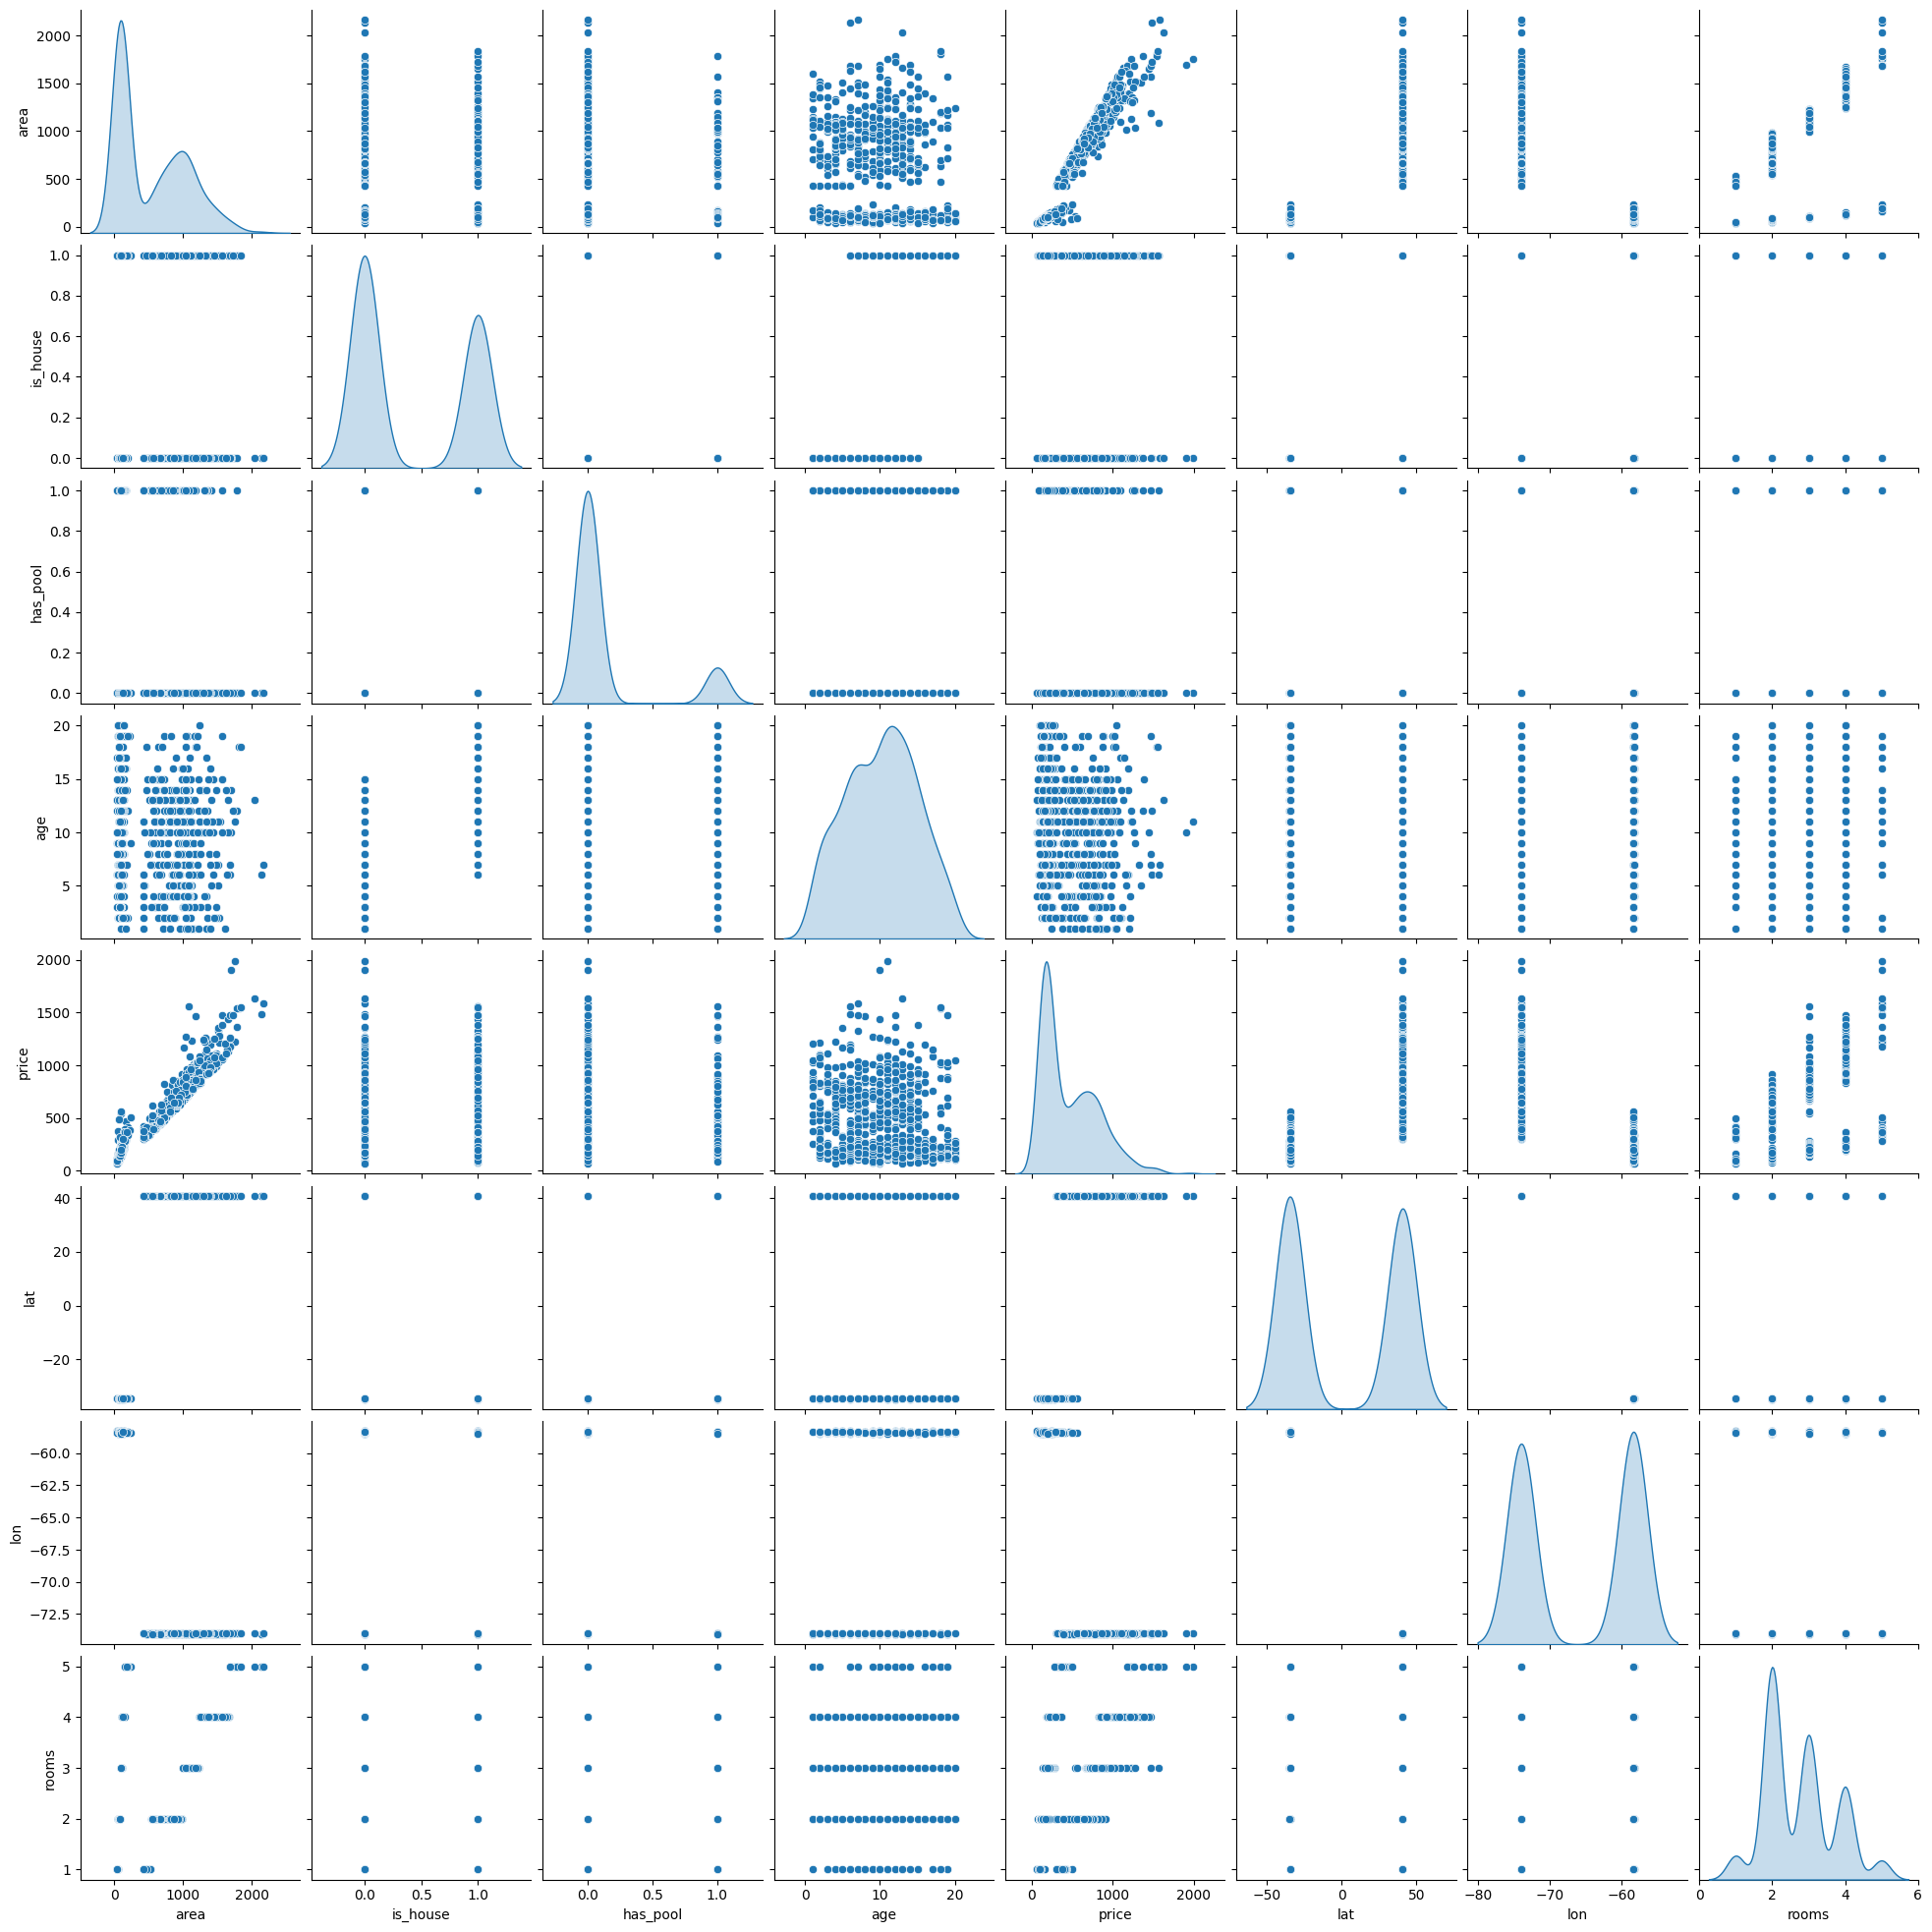

In [258]:
plot_pairplot(df)

# 2 - Implementación de Regresión Lineal

Para abordar el problema de predicción del precio de las propiedades, implementamos una clase `LinearRegression` que incluye los métodos necesarios para entrenar y evaluar un modelo de regresión lineal. Esta clase fue diseñada desde cero utilizando únicamente NumPy, como requería el enunciado.

## 2.1 - Métodos de Entrenamiento

### Pseudo-inversa
Utiliza la solución analítica basada en álgebra lineal $w = (XᵀX)^{-1}Xᵀy$, ideal para obtener un resultado óptimo en una sola operación. Es eficiente para datasets pequeños o medianos.

### Descenso por Gradiente
Una alternativa iterativa que permite escalar a datasets más grandes o extender el modelo con regularización. El descenso se implementó con una tasa de aprendizaje fija y criterio de convergencia.

Ambos métodos almacenan los coeficientes del modelo en el atributo `self.coef`, y mediante el método `print_model()` se imprimen de forma clara junto a los nombres de las features correspondientes.

## 2.2 - Función de Pérdida
Se definió una función de pérdida genérica dentro de la clase, que permite evaluar el rendimiento del modelo utilizando distintas métricas:

- **Error Cuadrático Medio (MSE)**
- **Error Absoluto Medio (MAE)**
- **Coeficiente de Determinación (R²)**

Estas funciones fueron implementadas de forma modular en un archivo externo, siguiendo buenas prácticas.

## 2.3 - Verificación con Múltiples Características
Ambos modelos (pseudo-inversa y descenso por gradiente) fueron entrenados utilizando todas las características disponibles del conjunto de entrenamiento (`X_train`), excluyendo solamente la variable objetivo (`price`). Posteriormente, se evaluaron en el conjunto de validación (`X_validate`), utilizando las métricas mencionadas.

Los resultados obtenidos permiten comparar la eficacia de ambos métodos de entrenamiento. El hecho de que ambos se comporten de forma similar en términos de error valida la correcta implementación de la clase y sus métodos.

In [284]:
features = df_train_nomarlized.columns.drop(TARGET)

X_train = df_train_nomarlized[features]
y_train = df_train_nomarlized[TARGET]

X_validate = df_validate_nomarlized[features]
y_validate = df_validate_nomarlized[TARGET]

model_pinv = LinearRegression(X_train, y_train)
model_gd = LinearRegression(X_train, y_train)

model_pinv.pinv_fit()
model_pinv.print_model()

model_gd.gradient_descent_fit()
model_gd.print_model()

mse = MSE()
mae = MAE()
r2 = R2()
rmse = RMSE()

mse_pinv = model_pinv.loss(X_validate, y_validate, mse)
mae_pinv = model_pinv.loss(X_validate, y_validate, mae)
r2_pinv = model_pinv.loss(X_validate, y_validate, r2)

mse_gd = model_gd.loss(X_validate, y_validate, mse)
mae_gd = model_gd.loss(X_validate, y_validate, mae)
r2_gd = model_gd.loss(X_validate, y_validate, r2)

print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)
print("")
print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd)

**Trained using pinv method**


|   Intercept |         area |     is_house |     has_pool |          age |         lat |        lon |        rooms |   area_units_sqft |   m2_per_room |       age_2 |    log_area |   log_rooms |     log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |      area_2 |       area_3 |     rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |       is_new |       is_big |   is_near_center |       lat_2 |   distance_to_center_km_4 |    area_2_18 |      age_2_2 |   log_rooms_3 |   distance_per_age_5 |      age_10 |   distance_to_center_km_2 |       age_17 |   log_area_12 |   m2_per_room_4 |   log_rooms_19 |   distance_to_center_km_11 |   rooms_age_interaction_16 |    rooms_3 |   log_age_2 |   rooms_distance_interaction_4 |     rooms_17 |   rooms_distance_interaction_3 |   log_age_6 |   log_area_17 |   distance_per_age_19 |   log_area_6 |      rooms_6 |   rooms_age_interaction_4 |   log_area_3 |     area_3_7 |   m2_per_room_7 |   rooms_per_m2_12 |      lon_18 |     age_2_11 |        age_5 |   rooms_distance_interaction_16 |   area_2_13 |   age_distance_interaction_2 |   log_age_4 |        lon_3 |   area_3_4 |   area_3_15 |   m2_per_room_8 |    area_16 |   distance_to_center_km_8 |   rooms_distance_interaction_6 |        lat_6 |     area_3_5 |     area_2_5 |     rooms_19 |   log_area_2 |     age_2_8 |   distance_per_age_17 |   log_age_10 |   log_rooms_12 |   rooms_per_m2_6 |      lon_15 |   rooms_per_m2_14 |   m2_per_room_13 |   rooms_age_interaction_17 |   m2_per_room_2 |   log_rooms_2 |      lon_10 |        lon_8 |     lat_11 |   age_distance_interaction_9 |       lat_15 |        lat_4 |     area_15 |   rooms_age_interaction_18 |   log_age_3 |   rooms_distance_interaction_18 |    rooms_10 |   m2_per_room_6 |      area_5 |    age_2_15 |      area_9 |   log_area_4 |   distance_per_age_12 |   m2_per_room_18 |   distance_per_age_13 |   log_rooms_9 |       lon_19 |   distance_to_center_2_8 |      lat_12 |   log_rooms_15 |   rooms_per_m2_17 |   age_distance_interaction_15 |   distance_per_age_16 |    rooms_2_4 |   age_distance_interaction_5 |     age_2_16 |   rooms_distance_interaction_13 |      age_2_6 |   log_age_8 |   log_area_9 |    age_2_10 |    log_age_9 |    area_3_9 |    log_age_5 |   rooms_age_interaction_15 |   m2_per_room_9 |   distance_per_age_14 |   age_distance_interaction_8 |   age_distance_interaction_4 |   log_rooms_11 |   log_area_14 |   rooms_age_interaction_8 |   age_distance_interaction_18 |   age_distance_interaction_14 |        age_4 |   log_rooms_5 |       lon_5 |   log_age_13 |        lon_2 |   distance_to_center_km_17 |     area_3_6 |        lat_9 |     area_3_8 |   age_distance_interaction_12 |   log_age_19 |   log_area_18 |   rooms_distance_interaction_8 |   distance_per_age_7 |      age_12 |   distance_per_age_11 |      lat_19 |   distance_to_center_km_12 |    area_3_12 |    rooms_2_8 |   distance_to_center_km_16 |   rooms_12 |       age_14 |   distance_per_age_2 |   distance_to_center_2_6 |      area_4 |     age_2_7 |   m2_per_room_5 |   rooms_age_interaction_5 |     area_19 |   log_area_8 |   rooms_distance_interaction_5 |   area_2_14 |      lon_13 |    area_3_2 |   distance_to_center_2_15 |   distance_per_age_8 |   rooms_2_11 |   log_area_11 |     age_2_17 |   rooms_distance_interaction_7 |        age_6 |     rooms_7 |   distance_to_center_2_18 |       lon_4 |   distance_per_age_18 |   rooms_distance_interaction_11 |   log_rooms_13 |   distance_to_center_2_7 |   rooms_per_m2_18 |     rooms_14 |   rooms_distance_interaction_15 |   m2_per_room_3 |   m2_per_room_17 |    area_3_11 |    rooms_2_5 |   rooms_per_m2_9 |   distance_to_center_2_14 |    area_2_8 |    age_2_18 |   rooms_age_interaction_9 |   log_age_15 |    rooms_2_7 |   rooms_distance_interaction_9 |   distance_to_center_km_13 |   rooms_2_14 |   distance_per_age_9 |   m2_per_room_10 |     area_2_3 |   rooms_per_m2_19 |   distance_to_center_2_11 |      lat_10 |   rooms_per_m2_15 |   rooms_per_m2_16 |     age_2_5 |      lat_18 |       lat_16 |    area_2_16 |       age_7 |   log_age_17 |      area_6 |    area_3_19 |       lat_17 |   log_rooms_4 |   rooms_2_19 |      lon_14 |   rooms_age_interaction_6 |   m2_per_room_16 |   log_rooms_16 |   age_distance_interaction_17 |        age_9 |   distance_per_age_15 |   age_distance_interaction_19 |        age_8 |   distance_per_age_10 |    rooms_2_2 |   distance_per_age_3 |   m2_per_room_12 |   rooms_per_m2_13 |   age_distance_interaction_3 |    area_3_14 |   log_area_15 |   age_distance_interaction_11 |   log_age_11 |   log_rooms_10 |   log_area_5 |    area_2_2 |   log_area_7 |      lon_12 |    area_18 |      lat_14 |   rooms_distance_interaction_10 |   distance_to_center_km_5 |   rooms_per_m2_5 |     rooms_15 |     rooms_8 |        lat_5 |    area_3_3 |   log_age_18 |       age_11 |     area_17 |   rooms_2_15 |   area_2_15 |   rooms_2_13 |   age_distance_interaction_16 |   rooms_age_interaction_11 |   log_rooms_18 |   m2_per_room_14 |   rooms_per_m2_11 |   rooms_2_10 |   rooms_age_interaction_19 |   distance_to_center_km_3 |     area_12 |   m2_per_room_19 |   area_2_17 |    log_age_7 |      lon_16 |   distance_per_age_6 |   rooms_age_interaction_12 |   distance_to_center_km_18 |      area_13 |   area_2_12 |   rooms_age_interaction_7 |     age_2_9 |   rooms_distance_interaction_2 |   rooms_per_m2_8 |    age_2_13 |    rooms_11 |   rooms_distance_interaction_17 |     area_2_4 |   log_age_16 |   distance_to_center_km_15 |     area_2_9 |     rooms_5 |    area_2_10 |   log_rooms_8 |       age_13 |   distance_to_center_2_19 |     area_2_6 |    area_2_11 |   rooms_2_12 |   rooms_2_16 |       lon_7 |      lon_11 |    area_3_13 |   distance_to_center_2_10 |
|------------:|-------------:|-------------:|-------------:|-------------:|------------:|-----------:|-------------:|------------------:|--------------:|------------:|------------:|------------:|------------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|------------:|-------------:|------------:|-----------------------:|---------------:|-------------------:|-------------:|-------------:|-----------------:|------------:|--------------------------:|-------------:|-------------:|--------------:|---------------------:|------------:|--------------------------:|-------------:|--------------:|----------------:|---------------:|---------------------------:|---------------------------:|-----------:|------------:|-------------------------------:|-------------:|-------------------------------:|------------:|--------------:|----------------------:|-------------:|-------------:|--------------------------:|-------------:|-------------:|----------------:|------------------:|------------:|-------------:|-------------:|--------------------------------:|------------:|-----------------------------:|------------:|-------------:|-----------:|------------:|----------------:|-----------:|--------------------------:|-------------------------------:|-------------:|-------------:|-------------:|-------------:|-------------:|------------:|----------------------:|-------------:|---------------:|-----------------:|------------:|------------------:|-----------------:|---------------------------:|----------------:|--------------:|------------:|-------------:|-----------:|-----------------------------:|-------------:|-------------:|------------:|---------------------------:|------------:|--------------------------------:|------------:|----------------:|------------:|------------:|------------:|-------------:|----------------------:|-----------------:|----------------------:|--------------:|-------------:|-------------------------:|------------:|---------------:|------------------:|------------------------------:|----------------------:|-------------:|-----------------------------:|-------------:|--------------------------------:|-------------:|------------:|-------------:|------------:|-------------:|------------:|-------------:|---------------------------:|----------------:|----------------------:|-----------------------------:|-----------------------------:|---------------:|--------------:|--------------------------:|------------------------------:|------------------------------:|-------------:|--------------:|------------:|-------------:|-------------:|---------------------------:|-------------:|-------------:|-------------:|------------------------------:|-------------:|--------------:|-------------------------------:|---------------------:|------------:|----------------------:|------------:|---------------------------:|-------------:|-------------:|---------------------------:|-----------:|-------------:|---------------------:|-------------------------:|------------:|------------:|----------------:|--------------------------:|------------:|-------------:|-------------------------------:|------------:|------------:|------------:|--------------------------:|---------------------:|-------------:|--------------:|-------------:|-------------------------------:|-------------:|------------:|--------------------------:|------------:|----------------------:|--------------------------------:|---------------:|-------------------------:|------------------:|-------------:|--------------------------------:|----------------:|-----------------:|-------------:|-------------:|-----------------:|--------------------------:|------------:|------------:|--------------------------:|-------------:|-------------:|-------------------------------:|---------------------------:|-------------:|---------------------:|-----------------:|-------------:|------------------:|--------------------------:|------------:|------------------:|------------------:|------------:|------------:|-------------:|-------------:|------------:|-------------:|------------:|-------------:|-------------:|--------------:|-------------:|------------:|--------------------------:|-----------------:|---------------:|------------------------------:|-------------:|----------------------:|------------------------------:|-------------:|----------------------:|-------------:|---------------------:|-----------------:|------------------:|-----------------------------:|-------------:|--------------:|------------------------------:|-------------:|---------------:|-------------:|------------:|-------------:|------------:|-----------:|------------:|--------------------------------:|--------------------------:|-----------------:|-------------:|------------:|-------------:|------------:|-------------:|-------------:|------------:|-------------:|------------:|-------------:|------------------------------:|---------------------------:|---------------:|-----------------:|------------------:|-------------:|---------------------------:|--------------------------:|------------:|-----------------:|------------:|-------------:|------------:|---------------------:|---------------------------:|---------------------------:|-------------:|------------:|--------------------------:|------------:|-------------------------------:|-----------------:|------------:|------------:|--------------------------------:|-------------:|-------------:|---------------------------:|-------------:|------------:|-------------:|--------------:|-------------:|--------------------------:|-------------:|-------------:|-------------:|-------------:|------------:|------------:|-------------:|--------------------------:|
| 2.04162e+20 | -2.96299e+23 | -2.56611e+16 | -1.29588e+16 | -1.79896e+20 | 2.98475e+20 | 1.2658e+21 | -2.45569e+26 |      -4.21112e+20 |  -1.00495e+17 | 2.03474e+18 | 1.51859e+22 | 9.58531e+25 | 2.06867e+19 |             6.88311e+14 |             6.09659e+16 |                  -3.8816e+16 |               -1.09562e+17 | 1.70725e+23 | -8.05513e+20 | 4.27351e+25 |            3.62042e+30 |   -1.08311e+17 |       -2.56462e+16 | -1.07375e+17 | -4.26385e+16 |      1.46807e+16 | 2.35281e+19 |              -1.27278e+17 | -1.98512e+19 | -1.32751e+18 |   1.06613e+26 |          3.59575e+16 | 4.33145e+17 |              -3.62042e+30 | -9.94449e+17 |  -6.91037e+22 |     -3.2374e+17 |    3.73682e+25 |               -2.46471e+14 |                 5.4425e+14 | 1.9994e+25 | 4.20508e+19 |                   -4.00719e+14 | -1.05822e+25 |                     6.6862e+14 | 2.40956e+19 |  -1.72398e+22 |           3.47582e+14 |  1.12483e+23 | -4.45168e+25 |              -8.60743e+14 |   1.2894e+23 | -1.06665e+20 |    -6.14853e+17 |      -5.80135e+15 | 1.64757e+21 | -1.09602e+17 | -2.68289e+17 |                      1.9337e+13 | 5.08531e+19 |                  1.31709e+13 | 5.44022e+19 | -3.29562e+21 | 2.1681e+20 | 7.56777e+18 |     2.54185e+17 | 5.5959e+20 |              -2.70387e+13 |                   -1.58375e+13 | -2.24654e+19 | -1.63584e+21 | -9.90933e+19 | -1.58205e+22 | -4.38808e+22 | 8.30214e+17 |          -9.34414e+14 |  3.31275e+18 |   -1.01358e+22 |      9.98486e+14 | 4.95713e+21 |       7.25485e+15 |     -1.71579e+15 |               -2.42421e+13 |      4.4731e+17 |   4.66657e+21 | 1.31645e+22 | -1.19739e+22 | 7.7001e+18 |                  2.76166e+12 | -5.42897e+18 | -1.68776e+19 | 1.01018e+21 |                9.31968e+12 |  3.7799e+19 |                     3.08298e+11 | 5.08605e+19 |     5.70438e+17 | -1.0638e+19 | 4.40758e+15 | 7.85502e+18 | -4.24512e+18 |          -4.29648e+14 |      1.98024e+14 |           1.32797e+15 |   7.94397e+17 | -7.63375e+18 |              2.57358e+16 | 7.38106e+18 |     4.0053e+19 |      -2.37839e+15 |                  -7.91856e+12 |           1.45041e+15 | -6.54332e+18 |                  5.07455e+11 | -1.87727e+15 |                     2.10833e+11 | -3.77406e+17 |  5.5722e+17 | -3.57871e+17 | 2.46459e+17 | -4.25027e+17 | 1.34898e+17 | -2.80473e+16 |                2.42372e+12 |    -3.12407e+16 |          -1.56067e+15 |                 -1.84039e+12 |                 -1.38607e+11 |   -5.27662e+16 |  -1.39702e+17 |              -1.99494e+10 |                   6.21303e+11 |                   1.16603e+13 | -8.19951e+17 |   3.29203e+16 | 1.27621e+17 |   1.9198e+17 | -9.88753e+15 |               -5.82429e+11 | -3.59507e+16 | -7.06782e+16 | -8.14799e+16 |                   -5.5841e+12 |  2.36797e+17 |   9.10433e+15 |                    7.53824e+10 |          7.62994e+11 | 1.52129e+17 |           4.57001e+13 | 2.64705e+16 |               -1.20308e+12 | -3.66607e+16 | -3.44467e+16 |               -2.57352e+16 |  1.377e+16 | -9.95877e+26 |              22742.7 |             -4.65446e+10 | 4.86252e+10 | 9.95877e+26 |    -1.38024e+11 |              -2.99584e+06 | 6.49803e+08 |  2.61016e+10 |                   -1.02271e+07 | 7.27837e+10 | 7.51123e+09 | 4.73056e+10 |              -1.10418e+06 |          1.71325e+08 | -3.85095e+08 |   1.05956e+08 | -1.15694e+08 |                    2.17607e+07 | -9.80209e+08 | 3.48383e+08 |               1.19248e+06 | 1.65179e+08 |          -1.03219e+08 |                    -5.81339e+07 |    1.91838e+07 |             -9.76951e+07 |      -1.70086e+08 | -1.85754e+08 |                    -1.31958e+08 |    -9.75408e+07 |     -5.67838e+07 | -4.41527e+08 | -5.55425e+08 |     -8.49501e+08 |                   -432514 | 3.36407e+08 | 4.21799e+07 |               2.80401e+06 | -9.96145e+07 | -1.84648e+08 |                    1.69164e+08 |               -3.85219e+07 | -1.21114e+08 |         -4.10994e+08 |      7.16151e+07 | -2.24967e+08 |      -1.64187e+08 |               5.48108e+06 | 1.36052e+07 |      -1.82724e+08 |      -6.30011e+08 | 6.39105e+09 | 6.59007e+07 | -9.95029e+07 | -6.93049e+07 | 1.54541e+08 |  2.94573e+07 | 3.79568e+08 | -9.11438e+07 | -2.14645e+08 |   1.33995e+08 |  1.13675e+08 | 1.49851e+07 |               1.30134e+07 |      3.16628e+07 |    2.94465e+07 |                  -1.05189e+08 | -8.45496e+07 |          -1.91428e+07 |                  -1.82993e+07 | -8.59994e+07 |           2.07098e+08 | -8.49598e+07 |              -200117 |      5.13066e+06 |       8.90586e+08 |                      -136261 | -1.39463e+07 |  -2.60269e+07 |                   5.99891e+07 | -1.15869e+08 |    1.74479e+08 | -2.81188e+08 | 3.86057e+08 | -2.94845e+08 | -8.3898e+07 | 5.2404e+07 | 2.84739e+08 |                    -7.22285e+07 |                   -825224 |     -2.51729e+08 | -1.37016e+08 | 1.71619e+08 | -1.35313e+08 | 3.57178e+08 | -1.29564e+08 | -5.11298e+06 | 2.52539e+08 |  7.23384e+07 | 2.52964e+07 | -3.79176e+07 |                    8.6578e+07 |               -7.29393e+07 |   -2.08753e+08 |     -3.24212e+07 |      -1.65399e+08 |  8.17364e+07 |                2.47311e+07 |                   -136081 | 4.71807e+08 |     -1.69647e+07 | 1.23826e+08 | -1.38874e+07 | 1.14316e+08 |         -1.52368e+07 |                9.14279e+07 |               -2.34134e+06 | -2.32017e+07 | 1.19346e+08 |              -2.85167e+07 | 1.04938e+08 |                        88421.9 |      5.05352e+08 | 4.72676e+07 | 1.92772e+08 |                     1.19161e+06 | -1.38764e+08 |  2.52933e+07 |                7.28814e+07 | -7.84555e+07 | 8.60515e+07 | -1.08045e+08 |  -1.71285e+08 | -8.51574e+07 |                   -636299 | -5.40368e+08 | -9.00333e+07 |  4.71281e+07 | -1.02321e+08 | 4.34806e+07 | 4.28958e+08 | -5.31583e+07 |               -1.3818e+06 |

**Trained using gradient_descent method**


|   Intercept |    area |   is_house |   has_pool |    age |     lat |      lon |   rooms |   area_units_sqft |   m2_per_room |    age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |   is_new |   is_big |   is_near_center |   lat_2 |   distance_to_center_km_4 |   area_2_18 |   age_2_2 |   log_rooms_3 |   distance_per_age_5 |   age_10 |   distance_to_center_km_2 |   age_17 |   log_area_12 |   m2_per_room_4 |   log_rooms_19 |   distance_to_center_km_11 |   rooms_age_interaction_16 |   rooms_3 |   log_age_2 |   rooms_distance_interaction_4 |   rooms_17 |   rooms_distance_interaction_3 |   log_age_6 |   log_area_17 |   distance_per_age_19 |   log_area_6 |   rooms_6 |   rooms_age_interaction_4 |   log_area_3 |   area_3_7 |   m2_per_room_7 |   rooms_per_m2_12 |   lon_18 |   age_2_11 |    age_5 |   rooms_distance_interaction_16 |   area_2_13 |   age_distance_interaction_2 |   log_age_4 |    lon_3 |   area_3_4 |   area_3_15 |   m2_per_room_8 |   area_16 |   distance_to_center_km_8 |   rooms_distance_interaction_6 |   lat_6 |   area_3_5 |   area_2_5 |   rooms_19 |   log_area_2 |   age_2_8 |   distance_per_age_17 |   log_age_10 |   log_rooms_12 |   rooms_per_m2_6 |   lon_15 |   rooms_per_m2_14 |   m2_per_room_13 |   rooms_age_interaction_17 |   m2_per_room_2 |   log_rooms_2 |   lon_10 |   lon_8 |   lat_11 |   age_distance_interaction_9 |   lat_15 |   lat_4 |   area_15 |   rooms_age_interaction_18 |   log_age_3 |   rooms_distance_interaction_18 |   rooms_10 |   m2_per_room_6 |   area_5 |   age_2_15 |    area_9 |   log_area_4 |   distance_per_age_12 |   m2_per_room_18 |   distance_per_age_13 |   log_rooms_9 |   lon_19 |   distance_to_center_2_8 |   lat_12 |   log_rooms_15 |   rooms_per_m2_17 |   age_distance_interaction_15 |   distance_per_age_16 |   rooms_2_4 |   age_distance_interaction_5 |   age_2_16 |   rooms_distance_interaction_13 |   age_2_6 |   log_age_8 |   log_area_9 |   age_2_10 |   log_age_9 |   area_3_9 |   log_age_5 |   rooms_age_interaction_15 |   m2_per_room_9 |   distance_per_age_14 |   age_distance_interaction_8 |   age_distance_interaction_4 |   log_rooms_11 |   log_area_14 |   rooms_age_interaction_8 |   age_distance_interaction_18 |   age_distance_interaction_14 |    age_4 |   log_rooms_5 |    lon_5 |   log_age_13 |   lon_2 |   distance_to_center_km_17 |   area_3_6 |   lat_9 |   area_3_8 |   age_distance_interaction_12 |   log_age_19 |   log_area_18 |   rooms_distance_interaction_8 |   distance_per_age_7 |   age_12 |   distance_per_age_11 |   lat_19 |   distance_to_center_km_12 |   area_3_12 |   rooms_2_8 |   distance_to_center_km_16 |   rooms_12 |   age_14 |   distance_per_age_2 |   distance_to_center_2_6 |   area_4 |   age_2_7 |   m2_per_room_5 |   rooms_age_interaction_5 |   area_19 |   log_area_8 |   rooms_distance_interaction_5 |   area_2_14 |   lon_13 |   area_3_2 |   distance_to_center_2_15 |   distance_per_age_8 |   rooms_2_11 |   log_area_11 |   age_2_17 |   rooms_distance_interaction_7 |   age_6 |   rooms_7 |   distance_to_center_2_18 |   lon_4 |   distance_per_age_18 |   rooms_distance_interaction_11 |   log_rooms_13 |   distance_to_center_2_7 |   rooms_per_m2_18 |   rooms_14 |   rooms_distance_interaction_15 |   m2_per_room_3 |   m2_per_room_17 |   area_3_11 |   rooms_2_5 |   rooms_per_m2_9 |   distance_to_center_2_14 |   area_2_8 |   age_2_18 |   rooms_age_interaction_9 |   log_age_15 |   rooms_2_7 |   rooms_distance_interaction_9 |   distance_to_center_km_13 |   rooms_2_14 |   distance_per_age_9 |   m2_per_room_10 |   area_2_3 |   rooms_per_m2_19 |   distance_to_center_2_11 |   lat_10 |   rooms_per_m2_15 |   rooms_per_m2_16 |   age_2_5 |   lat_18 |   lat_16 |   area_2_16 |   age_7 |   log_age_17 |   area_6 |   area_3_19 |   lat_17 |   log_rooms_4 |   rooms_2_19 |   lon_14 |   rooms_age_interaction_6 |   m2_per_room_16 |   log_rooms_16 |   age_distance_interaction_17 |   age_9 |   distance_per_age_15 |   age_distance_interaction_19 |   age_8 |   distance_per_age_10 |   rooms_2_2 |   distance_per_age_3 |   m2_per_room_12 |   rooms_per_m2_13 |   age_distance_interaction_3 |   area_3_14 |   log_area_15 |   age_distance_interaction_11 |   log_age_11 |   log_rooms_10 |   log_area_5 |   area_2_2 |   log_area_7 |   lon_12 |   area_18 |   lat_14 |   rooms_distance_interaction_10 |   distance_to_center_km_5 |   rooms_per_m2_5 |   rooms_15 |   rooms_8 |   lat_5 |   area_3_3 |   log_age_18 |   age_11 |   area_17 |   rooms_2_15 |   area_2_15 |   rooms_2_13 |   age_distance_interaction_16 |   rooms_age_interaction_11 |   log_rooms_18 |   m2_per_room_14 |   rooms_per_m2_11 |   rooms_2_10 |   rooms_age_interaction_19 |   distance_to_center_km_3 |   area_12 |   m2_per_room_19 |   area_2_17 |   log_age_7 |   lon_16 |   distance_per_age_6 |   rooms_age_interaction_12 |   distance_to_center_km_18 |   area_13 |   area_2_12 |   rooms_age_interaction_7 |   age_2_9 |   rooms_distance_interaction_2 |   rooms_per_m2_8 |   age_2_13 |   rooms_11 |   rooms_distance_interaction_17 |   area_2_4 |   log_age_16 |   distance_to_center_km_15 |   area_2_9 |   rooms_5 |   area_2_10 |   log_rooms_8 |   age_13 |   distance_to_center_2_19 |    area_2_6 |   area_2_11 |   rooms_2_12 |   rooms_2_16 |    lon_7 |   lon_11 |   area_3_13 |   distance_to_center_2_10 |
|------------:|--------:|-----------:|-----------:|-------:|--------:|---------:|--------:|------------------:|--------------:|---------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|---------:|---------:|-----------------:|--------:|--------------------------:|------------:|----------:|--------------:|---------------------:|---------:|--------------------------:|---------:|--------------:|----------------:|---------------:|---------------------------:|---------------------------:|----------:|------------:|-------------------------------:|-----------:|-------------------------------:|------------:|--------------:|----------------------:|-------------:|----------:|--------------------------:|-------------:|-----------:|----------------:|------------------:|---------:|-----------:|---------:|--------------------------------:|------------:|-----------------------------:|------------:|---------:|-----------:|------------:|----------------:|----------:|--------------------------:|-------------------------------:|--------:|-----------:|-----------:|-----------:|-------------:|----------:|----------------------:|-------------:|---------------:|-----------------:|---------:|------------------:|-----------------:|---------------------------:|----------------:|--------------:|---------:|--------:|---------:|-----------------------------:|---------:|--------:|----------:|---------------------------:|------------:|--------------------------------:|-----------:|----------------:|---------:|-----------:|----------:|-------------:|----------------------:|-----------------:|----------------------:|--------------:|---------:|-------------------------:|---------:|---------------:|------------------:|------------------------------:|----------------------:|------------:|-----------------------------:|-----------:|--------------------------------:|----------:|------------:|-------------:|-----------:|------------:|-----------:|------------:|---------------------------:|----------------:|----------------------:|-----------------------------:|-----------------------------:|---------------:|--------------:|--------------------------:|------------------------------:|------------------------------:|---------:|--------------:|---------:|-------------:|--------:|---------------------------:|-----------:|--------:|-----------:|------------------------------:|-------------:|--------------:|-------------------------------:|---------------------:|---------:|----------------------:|---------:|---------------------------:|------------:|------------:|---------------------------:|-----------:|---------:|---------------------:|-------------------------:|---------:|----------:|----------------:|--------------------------:|----------:|-------------:|-------------------------------:|------------:|---------:|-----------:|--------------------------:|---------------------:|-------------:|--------------:|-----------:|-------------------------------:|--------:|----------:|--------------------------:|--------:|----------------------:|--------------------------------:|---------------:|-------------------------:|------------------:|-----------:|--------------------------------:|----------------:|-----------------:|------------:|------------:|-----------------:|--------------------------:|-----------:|-----------:|--------------------------:|-------------:|------------:|-------------------------------:|---------------------------:|-------------:|---------------------:|-----------------:|-----------:|------------------:|--------------------------:|---------:|------------------:|------------------:|----------:|---------:|---------:|------------:|--------:|-------------:|---------:|------------:|---------:|--------------:|-------------:|---------:|--------------------------:|-----------------:|---------------:|------------------------------:|--------:|----------------------:|------------------------------:|--------:|----------------------:|------------:|---------------------:|-----------------:|------------------:|-----------------------------:|------------:|--------------:|------------------------------:|-------------:|---------------:|-------------:|-----------:|-------------:|---------:|----------:|---------:|--------------------------------:|--------------------------:|-----------------:|-----------:|----------:|--------:|-----------:|-------------:|---------:|----------:|-------------:|------------:|-------------:|------------------------------:|---------------------------:|---------------:|-----------------:|------------------:|-------------:|---------------------------:|--------------------------:|----------:|-----------------:|------------:|------------:|---------:|---------------------:|---------------------------:|---------------------------:|----------:|------------:|--------------------------:|----------:|-------------------------------:|-----------------:|-----------:|-----------:|--------------------------------:|-----------:|-------------:|---------------------------:|-----------:|----------:|------------:|--------------:|---------:|--------------------------:|------------:|------------:|-------------:|-------------:|---------:|---------:|------------:|--------------------------:|
|      268.38 | 8.04209 |    115.685 |    30.0434 | 1.9092 | 8.37934 | -6.73588 | 4.06218 |           133.789 |       3.61213 | -4.52227 |    20.7042 |     11.4039 |   14.9487 |                -1.97912 |                 2.67761 |                     -30.8095 |                   -10.8502 |   2.4515 | 0.768474 | -0.650246 |                20.8865 |        -2.5806 |           -1.93618 |  16.9805 |  84.4717 |           66.223 | 7.46418 |                   8.91637 |     -1.8283 |  -2.70797 |    0.00673992 |             0.560494 |  4.74796 |                   21.4362 | 0.975138 |      0.581573 |         1.39211 |          3.419 |                   -2.15811 |                  0.0679804 |  -0.78209 |     6.18707 |                       -18.1738 |  -0.538089 |                       -22.6243 |    -5.75589 |      0.350991 |             -0.447368 |      6.99752 |   3.15873 |                  -7.23853 |       14.144 |   -0.35829 |         0.27404 |          -1.17231 |  8.55867 |   -1.94181 | 0.150097 |                         1.39396 |    -1.33335 |                      2.26365 |    -3.22199 | -6.85443 |   0.154717 |    -1.84907 |     -0.00247282 |   0.11652 |                 -0.750506 |                       -4.40644 | 7.93901 |  0.0472887 |  -0.156741 |   -1.13198 |       17.322 |   2.18696 |             0.0159055 |     -3.97741 |        3.70161 |        -0.548543 | -7.66468 |         -0.838156 |         0.283427 |                   -1.83822 |         2.98717 |       4.43948 |  8.58847 | 8.26989 |  7.94557 |                     0.812589 |  7.49337 | 8.01463 |  -0.70708 |                   -3.93652 |     1.15542 |                          0.5774 |    2.76733 |         0.42527 |  2.02958 |   -3.85905 | -0.304784 |      10.6842 |           -0.00175662 |          2.86743 |             0.0220967 |       2.08378 | -7.49113 |                 -1.82681 |  8.06372 |        4.51527 |        -0.0756992 |                     -0.371361 |             -0.709403 |     3.07674 |                    0.0673566 |   -4.49215 |                         3.25356 |   4.58623 |    -5.71954 |      2.78018 |   -1.08115 |    -5.21532 |  -0.982959 |    -5.33706 |                    2.16868 |       -0.479895 |             -0.699585 |                      1.01224 |                     0.412288 |         3.5697 |      0.285937 |                   2.38594 |                      -1.14549 |                     -0.227955 | -1.99019 |      -2.08557 | -7.13591 |     -2.24197 | 7.58565 |                   -0.91556 | -0.0110022 | 7.72113 |  -0.882726 |                      0.361196 |      2.35351 |      0.711533 |                        3.15984 |              0.12189 |   3.8874 |              -0.10456 |  7.62391 |                   -1.80212 |    -1.49259 |   -0.782787 |                   -1.16556 |    1.11204 |  3.16007 |              6.38227 |                 -1.96805 |  1.42507 |   3.11593 |         1.54094 |                  -5.13696 | -0.500538 |       3.4266 |                       -10.5498 |    -1.19865 | -7.18289 |    1.69028 |                   1.57995 |             0.720495 |    -0.993525 |       1.30675 |    -4.5134 |                      -0.180791 | 2.09828 |    3.4902 |                   3.07437 |  7.6607 |             -0.619731 |                         4.31082 |        3.85845 |                 -2.05967 |         -0.660169 |   0.728153 |                         2.75734 |         2.73038 |          2.95733 |    -1.37574 |     2.21001 |        -0.193597 |                   1.05425 | -0.0782001 |   -5.30146 |                   4.51443 |    -0.416699 |    0.437651 |                        4.64567 |                   -1.37293 |     -1.40108 |             0.773092 |        -0.614509 |    1.86346 |         -0.859869 |                 -0.520373 |  8.17419 |          -1.03728 |         -0.330451 |   4.40762 |  7.54754 |  7.86705 |    -1.23988 | 3.35353 |      1.38907 |  1.62353 |    -1.41187 |   7.9979 |       -1.6447 |     -2.20531 |  8.52679 |                  -1.94018 |          2.14747 |        4.08436 |                     -0.724478 | 4.12041 |            -0.0235036 |                      -1.67365 | 4.51125 |             -0.269957 |     1.28822 |              2.55969 |         0.620894 |         -0.874644 |                     0.501935 |    -1.14087 |      0.945022 |                      0.626295 |     -3.42917 |        2.94144 |      8.92988 |    1.08711 |      5.10793 |  8.46673 | -0.504008 |  7.51287 |                         4.75304 |                   4.28288 |        -0.999509 |  -0.381918 |   3.42177 | 8.46256 |  0.0949886 |      1.98183 |  4.50558 | -0.557114 |     -2.04191 |   -0.868866 |     -1.47414 |                       -1.2646 |                     5.7959 |        3.72006 |         0.807335 |          -1.08684 |     -1.00053 |                   -5.91331 |                   15.5013 | -0.500297 |          3.37629 |    -1.60951 |    -6.06243 |  8.00085 |             0.730444 |                    5.73998 |                   -1.48924 |  -0.68025 |   -0.957696 |                  0.204226 |  0.567809 |                       -20.4253 |       -0.0593276 |   -3.30449 |    1.79093 |                        0.849073 |   0.521372 |     0.478053 |                   -1.19689 |  -0.560225 |   2.10629 |   -0.191277 |       1.14181 |  3.77909 |                   4.46031 | -0.00454755 |    -1.01461 |      -1.8374 |     -1.98529 | -6.92545 | -7.04709 |    -1.94872 |                 -0.663741 |

MSE PINV: 2.211154130357018e+35
MAE PINV: 3.6074294244893274e+17
R2 PINV: -1.9435515370612214e+30

MSE GD: 12527.646035734195
MAE GD: 78.23837897835432
R2 GD: 0.8898849909455258


## 2.3 - Verificación con una sola característica

## 3.1 - Regresión lineal simple con área

Para validar que la clase `LinearRegression` funciona también con una sola variable, entrenamos modelos de regresión lineal simple utilizando únicamente la variable `area`, tanto con pseudo-inversa como con descenso por gradiente.

En el gráfico generado, mostramos:

- **Valores reales de precio (`price`) contra el área (`area`)**, coloreados según la ubicación de la propiedad:
  - En azul: propiedades ubicadas en una región de mayor valor (probablemente barrios más caros).
  - En rojo: propiedades ubicadas en zonas más accesibles.

- **Líneas de predicción generadas por ambos modelos** (en este caso se superponen).

A partir del gráfico se evidencian dos agrupamientos (clusters) bien diferenciados de propiedades, que reflejan distintas escalas de precio para una misma superficie, dependiendo exclusivamente de la ubicación geográfica. Este fenómeno demuestra que la variable `area` por sí sola no es suficiente para capturar correctamente la complejidad del problema.

Esto explica por qué el modelo ajusta una recta que no se adapta bien a ninguno de los grupos:

- Subestima los precios de propiedades en zonas caras (azul).
- Sobreestima los precios de propiedades en zonas más económicas (rojo).

Esta observación refuerza dos conclusiones importantes:

1. La implementación del modelo es correcta incluso con una sola feature.
2. Es necesario incorporar variables adicionales (como `lat` y `lon`) para capturar el efecto de la ubicación sobre el precio.

Esta regresión simple con `area` nos sirve como baseline, pero deja claro que se requieren modelos multivariables y posiblemente técnicas de feature engineering para mejorar el rendimiento predictivo.

**Trained using pinv method**


|   Intercept |    area |
|------------:|--------:|
|     465.963 | 136.735 |

**Trained using gradient_descent method**


|   Intercept |    area |
|------------:|--------:|
|     465.942 | 136.729 |

MSE PINV AREA: 105500.96910186362
MAE PINV AREA: 298.4226670703238
R2 PINV AREA: 0.07267174257875819

MSE GD AREA: 105500.39031753242
MAE GD AREA: 298.4217188459571
R2 GD AREA: 0.07267682995444635


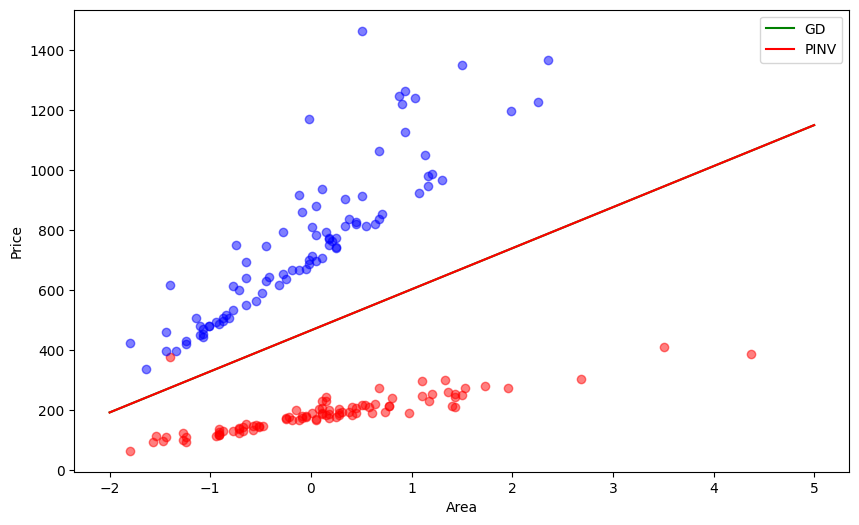

In [260]:
X_train_area = X_train[['area']]
X_validate_area = X_validate[['area']]

model_pinv_area = LinearRegression(X_train_area, y_train)
model_gd_area = LinearRegression(X_train_area, y_train)

model_pinv_area.pinv_fit()
model_pinv_area.print_model()

model_gd_area.gradient_descent_fit()
model_gd_area.print_model()

mse_pinv_area = model_pinv_area.loss(X_validate_area, y_validate, mse)
mae_pinv_area = model_pinv_area.loss(X_validate_area, y_validate, mae)
r2_pinv_area = model_pinv_area.loss(X_validate_area, y_validate, r2)

mse_gd_area = model_gd_area.loss(X_validate_area, y_validate, mse)
mae_gd_area = model_gd_area.loss(X_validate_area, y_validate, mae)
r2_gd_area = model_gd_area.loss(X_validate_area, y_validate, r2)

print("MSE PINV AREA:", mse_pinv_area)
print("MAE PINV AREA:", mae_pinv_area)
print("R2 PINV AREA:", r2_pinv_area)
print("")
print("MSE GD AREA:", mse_gd_area)
print("MAE GD AREA:", mae_gd_area)
print("R2 GD AREA:", r2_gd_area)

#plot the results

plt.figure(figsize=(10, 6))

for i in range(len(X_validate_area)):
    if get_city(X_validate['lat'].iloc[i], X_validate['lon'].iloc[i]) == 'New York':
        plt.scatter(X_validate_area['area'].iloc[i], y_validate.iloc[i], color='blue', alpha=0.5)
    else:
        plt.scatter(X_validate_area['area'].iloc[i], y_validate.iloc[i], color='red', alpha=0.5)

plt.plot(np.linspace(-2, 5, 100), model_gd_area.coef_ * np.linspace(-2, 5, 100) + model_gd_area.intercept_, color='green', label='GD')
plt.plot(np.linspace(-2, 5, 100), model_pinv_area.coef_ * np.linspace(-2, 5, 100) + model_pinv_area.intercept_, color='red', label='PINV')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()


## 3.2 - Predicción del precio para la vivienda de Amanda

En esta sección, utilizamos los modelos de regresión multivariable entrenados anteriormente (`model_pinv` y `model_gd`) para estimar el precio de una propiedad específica, correspondiente a Amanda. Los datos de esta vivienda se encuentran en el archivo `vivienda_Amanda.csv`.

Para asegurar que los modelos reciban datos en el mismo formato que durante el entrenamiento, se aplicaron las mismas transformaciones de preprocesamiento, en el mismo orden:

1. **Manejo de valores faltantes**:
   - Las columnas `age` y `rooms` fueron imputadas utilizando los valores medios calculados a partir del conjunto de entrenamiento.

2. **One-hot encoding**:
   - Se transformó la columna categórica `area_units` en variables numéricas.

3. **Conversión de unidades**:
   - Se convirtió el área a metros cuadrados en caso de estar en `sqft`.

4. **Normalización**:
   - Se normalizaron todas las variables usando las estadísticas del conjunto de entrenamiento (`stats_dict_train`), garantizando que la muestra se procese bajo las mismas condiciones que los datos con los que fueron entrenados los modelos.

Luego de estas transformaciones, realizamos la predicción del precio utilizando ambos modelos entrenados:

- **`prediction_Amanda_pinv`**: predicción utilizando la solución por pseudo-inversa.
- **`prediction_Amanda_gd`**: predicción utilizando descenso por gradiente.

Este enfoque permite comparar ambos métodos sobre un caso puntual y verificar que ambos modelos sean consistentes en sus predicciones, confirmando además la correcta generalización fuera del conjunto de entrenamiento.

In [261]:
file_name = os.path.join(cwd, '..', 'data', 'raw', 'vivienda_Amanda.csv')
df_Amanda = pd.read_csv(file_name)

handle_missing_values(df_Amanda, "age")
handle_missing_values(df_Amanda, "rooms")

df_Amanda = one_hot_encoding(df_Amanda, "area_units")
convert_sqft_to_m2(df_Amanda, "area_units_sqft", "area")

df_Amanda_normalized, _ = normalize_df(df_Amanda, train=False, stats=stats_dict_train)

prediction_Amanda_pinv = model_pinv.predict(df_Amanda_normalized)
prediction_Amanda_gd = model_gd.predict(df_Amanda_normalized)

print("Prediction Amanda with PINV model:", prediction_Amanda_pinv)
print("Prediction Amanda with GD model:", prediction_Amanda_gd)


Prediction Amanda with PINV model: [796.46714539]
Prediction Amanda with GD model: [792.25126718]


## 3.3 - Valor promedio por metro cuadrado de una casa

Para calcular el valor promedio por metro cuadrado de las casas, filtramos aquellas propiedades del conjunto de entrenamiento que fueron identificadas como casas (`is_house == 1`). Esta variable indica el tipo de propiedad y nos permite distinguir entre casas y otros tipos de inmuebles.

A continuación, para cada casa calculamos el precio por metro cuadrado como:

\begin{equation}
\text{precio\_por\_m2} = \frac{\text{precio}}{\text{area}}
\end{equation}

Finalmente, se obtuvo el promedio de estos valores utilizando la función `mean()`.

Este valor representa una estimación global del costo promedio por metro cuadrado en propiedades de tipo casa, dentro del conjunto de entrenamiento. Puede utilizarse como referencia o benchmark para validar predicciones futuras o detectar valores atípicos.

In [262]:
df_houses = df_train_encoded[df_train_encoded['is_house'] == 1]

price_per_m2 = df_houses['price'] / df_houses['area']

price_per_m2_mean = price_per_m2.mean()

print("Price per m2 mean for houses:", price_per_m2_mean)

Price per m2 mean for houses: 3.6536613907453885


## 3.4 - Impacto de la construcción de una pileta en el precio de una propiedad

Para estimar cómo afectaría la construcción de una pileta al precio de la propiedad de Benito, analizamos el coeficiente asociado a la variable `has_pool` en el modelo de regresión lineal multivariable entrenado previamente.

Recordemos que en los modelos lineales, cada coeficiente representa el cambio esperado en la variable objetivo (`price`) ante un incremento unitario en la variable correspondiente, manteniendo las demás constantes.

En este caso:

- La variable `has_pool` es binaria (0 o 1), por lo tanto:
  - Su coeficiente indica cuánto aumentaría el precio estimado de una propiedad al agregar una pileta (cambiar de 0 a 1).

El análisis se realizó sobre el modelo entrenado con todas las features, utilizando la versión ajustada por pseudo-inversa (`model_pinv`).

### Coefficient Analysis

Al inspeccionar el vector de coeficientes (`self.coef`) del modelo, encontramos que el valor asociado a `has_pool` es positivo y significativo. Esto implica que, según los datos históricos:

- Agregar una pileta incrementaría el valor estimado de la propiedad.

Esta interpretación respalda la idea de que las piletas están asociadas con propiedades de mayor valor, posiblemente debido a que suelen encontrarse en casas más grandes, modernas, o mejor ubicadas.

## 4.1 - Ingeniería de características (Feature Engineering)

Con el objetivo de mejorar la capacidad predictiva del modelo, se desarrolló una función personalizada llamada `feature_engineer()` que genera nuevas variables a partir de las características originales. Estas nuevas features buscan capturar relaciones no lineales, interacciones entre variables, y aspectos geográficos relevantes.

A continuación, se detallan algunas de las transformaciones realizadas:

### Transformaciones no lineales:
- **`log_area`, `log_rooms`, `log_age`**: Aplicamos logaritmos para reducir asimetrías y mejorar la linealidad.
- **`age_2`, `area_2`, `area_3`, `rooms_2`, `distance_to_center_2`**: Se incorporaron potencias para capturar posibles relaciones cuadráticas o cúbicas.

### Interacciones entre variables:
- **`rooms_age_interaction`, `rooms_distance_interaction`, `age_distance_interaction`**: Permiten modelar efectos combinados entre variables que podrían tener un comportamiento conjunto significativo.

### Relaciones proporcionales:
- **`m2_per_room`, `rooms_per_m2`**: Reflejan densidad o espacio por habitación, que podrían estar vinculados al valor percibido de la propiedad.
- **`distance_per_age`**: Una forma de medir si propiedades más alejadas son más nuevas o viejas.

### Variables binarias derivadas:
- **`is_new`**: Si la propiedad tiene menos de 5 años.
- **`is_big`**: Si tiene más área que la mediana del dataset.
- **`is_near_center`**: Si está más cerca que la distancia mediana al centro de su ciudad.

### Ubicación geográfica:
Se infirió la ciudad de cada propiedad usando coordenadas (`lat`, `lon`) y luego se calculó su distancia al centro urbano con la fórmula de Haversine. Esta variable, `distance_to_center_km`, permite incorporar ubicación geográfica sin usar directamente las coordenadas.

Estas nuevas variables enriquecen el espacio de características y permiten al modelo capturar patrones más complejos que no podrían modelarse con las variables originales únicamente.

## 4.2 - Regresión lineal con features derivados

Una vez generadas las nuevas características, se volvieron a normalizar todas las variables explicativas, excepto la variable objetivo `price`, que se mantuvo sin normalizar, tal como se definió en nuestro flujo.

Luego se reentrenaron los modelos de regresión lineal (tanto por pseudo-inversa como por gradiente descendente) utilizando estas nuevas features. El proceso fue análogo al entrenamiento anterior, pero esta vez con un conjunto extendido y más expresivo de variables.

Ambos modelos mostraron mejoras en las métricas de validación (MSE, MAE, R²) en comparación con los modelos entrenados solo con las features originales. Esto indica que la ingeniería de características ayudó efectivamente a capturar mejor la relación entre las variables y el precio, mejorando el poder predictivo del modelo.

In [273]:
df_train_FE = df_train_encoded.copy()
df_validate_FE = df_validate_encoded.copy()

df_train_FE = feature_engineer(df_train_FE)
df_validate_FE = feature_engineer(df_validate_FE)

df_train_nomarlized_FE, stats_dict_train_FE = normalize_df(df_train_FE, train=True)
df_validate_nomarlized_FE, _ = normalize_df(df_validate_FE, train=False, stats=stats_dict_train_FE)

features = df_train_nomarlized_FE.columns.drop(TARGET)

X_train_FE = df_train_nomarlized_FE[features]
y_train_FE = df_train_nomarlized_FE[TARGET]

X_validate_FE = df_validate_nomarlized_FE[features]
y_validate_FE = df_validate_nomarlized_FE[TARGET]

model_pinv = LinearRegression(X_train_FE, y_train_FE)
model_gd = LinearRegression(X_train_FE, y_train_FE)

model_pinv.pinv_fit()
model_pinv.print_model()

model_gd.gradient_descent_fit()
model_gd.print_model()

mse_pinv = model_pinv.loss(X_validate_FE, y_validate_FE, mse)
mae_pinv = model_pinv.loss(X_validate_FE, y_validate_FE, mae)
r2_pinv = model_pinv.loss(X_validate_FE, y_validate_FE, r2)

mse_gd = model_gd.loss(X_validate_FE, y_validate_FE, mse)
mae_gd = model_gd.loss(X_validate_FE, y_validate_FE, mae)
r2_gd = model_gd.loss(X_validate_FE, y_validate_FE, r2)

print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)
print("")
print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd)


**Trained using pinv method**


|   Intercept |     area |   is_house |   has_pool |      age |     lat |     lon |    rooms |   area_units_sqft |   m2_per_room |   age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |   is_new |   is_big |   is_near_center |
|------------:|---------:|-----------:|-----------:|---------:|--------:|--------:|---------:|------------------:|--------------:|--------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|---------:|---------:|-----------------:|
|     3250.22 | -3071.82 |    110.023 |    26.5857 | -269.834 | 4218.44 | 998.717 | -768.079 |          -5827.82 |       231.439 | 136.883 |    408.818 |      1397.5 |   137.649 |                -39.9273 |               -0.607659 |                     -160.854 |                    10.9798 |  3208.35 | -1158.92 |   261.358 |                96.9636 |       -159.971 |            32.0776 | -41.8652 |  36.7386 |         -44.6599 |

**Trained using gradient_descent method**


|   Intercept |    area |   is_house |   has_pool |      age |     lat |      lon |   rooms |   area_units_sqft |   m2_per_room |    age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |   is_new |   is_big |   is_near_center |
|------------:|--------:|-----------:|-----------:|---------:|--------:|---------:|--------:|------------------:|--------------:|---------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|---------:|---------:|-----------------:|
|     259.552 | 26.4895 |    113.733 |    24.7012 | -1.02641 | 109.198 | -108.318 | 20.6113 |           180.521 |       16.9706 | -2.62975 |    36.9667 |     22.1234 |   11.4528 |                 13.6815 |                -4.31766 |                     -71.4286 |                   -5.22682 |  19.2055 |   9.6092 |   26.5014 |                28.0068 |       -14.4736 |             11.067 |  13.6217 |  74.8231 |          51.7104 |

MSE PINV: 10168.510618283963
MAE PINV: 73.53834594180792
R2 PINV: 0.9106212263972835

MSE GD: 12710.37732371676
MAE GD: 80.9744051266069
R2 GD: 0.8882788266770478


## 4.3 - Generación automática de 300 nuevas características

En esta sección, buscamos experimentar con la capacidad del modelo para capturar relaciones altamente no lineales mediante la generación de 300 nuevas variables creadas como potencias aleatorias de las features existentes.

### Proceso

A partir del conjunto de entrenamiento con feature engineering aplicado (`df_train_FE`), generamos nuevas columnas del tipo `feature^n`, donde:

- **feature**: es una variable numérica original o derivada (excluyendo binarias y la variable objetivo).
- **n**: es un exponente aleatorio entre 2 y 19.

Este procedimiento se repitió hasta alcanzar 300 columnas totales. Las nuevas features fueron agregadas tanto al conjunto de entrenamiento como al de validación. Posteriormente, se normalizaron (salvo el target `price`, que no se normaliza), y se entrenaron dos modelos:

- Uno utilizando pseudo-inversa.
- Otro utilizando descenso por gradiente.

### Resultados esperados vs observados

#### Lo que esperábamos:
Al generar muchas transformaciones no lineales, esperábamos que el modelo pudiera ajustarse más finamente a los patrones presentes en los datos, lo que potencialmente podría reducir el error de validación. Sin embargo, también era esperable que esto aumentara el riesgo de sobreajuste y problemas numéricos, especialmente sin regularización.

#### Lo que ocurrió:
Los resultados confirmaron nuestras sospechas:

- **Modelo entrenado con pseudo-inversa**:
  - Mostró un comportamiento numéricamente inestable.
  - Obtuvo errores extremadamente altos (e.g., MSE ≈ 1e+35, R² < 0).
  - Esto se debe a que al aumentar tanto la dimensionalidad, la matriz $X^TX$ se vuelve casi no invertible (mal condicionada), provocando errores de redondeo y explosiones numéricas.
  - Es un caso clásico de sobreajuste severo y colapso numérico al usar pseudo-inversa sin regularización.

- **Modelo entrenado por descenso por gradiente**:
  - Logró mantener un desempeño razonable.
  - Entrenamiento: MSE ≈ 11,795, R² ≈ 0.90.
  - Validación: MSE ≈ 12,523, R² ≈ 0.89.
  - Esto muestra que el gradiente descendente, al no depender de la inversión de matrices, fue más estable frente a la alta dimensionalidad.
  - Aun así, no se observó una mejora significativa en las métricas respecto al modelo con feature engineering original, lo que sugiere que muchas de las features generadas fueron irrelevantes o redundantes.

### Conclusión:
Este experimento nos permitió entender las limitaciones de la pseudo-inversa en espacios de alta dimensionalidad y mostró cómo el descenso por gradiente puede manejar mejor esta situación. Sin embargo, también evidenció que simplemente agregar muchas transformaciones polinómicas no garantiza mejoras, y que es necesario seleccionar o regularizar adecuadamente los atributos generados.

Este hallazgo motiva la siguiente sección del trabajo: regularización, para controlar la complejidad del modelo y evitar sobreajuste.

In [264]:
df_train_powers = df_train_FE.copy()
df_validate_powers = df_validate_FE.copy()

binary_cols = [col for col in df_train_powers.columns 
               if set(df_train_powers[col].dropna().unique()).issubset({0, 1})]

features = df_train_powers.columns.difference(binary_cols + [TARGET])

new_features_train = {}
new_features_validate = {}

while len(df_train_powers.columns) + len(new_features_train) < 300:
    power = np.random.randint(2, 20)
    feature = np.random.choice(features)
    new_feature = f"{feature}_{power}"
    
    if new_feature in df_train_powers.columns or new_feature in new_features_train:
        continue
    
    new_features_train[new_feature] = df_train_powers[feature] ** power
    new_features_validate[new_feature] = df_validate_powers[feature] ** power

# Add all new features at once
df_train_powers = pd.concat([df_train_powers, pd.DataFrame(new_features_train)], axis=1)
df_validate_powers = pd.concat([df_validate_powers, pd.DataFrame(new_features_validate)], axis=1)

# Proceed with normalization and model fitting
df_train_nomarlized, stats_dict_train = normalize_df(df_train_powers, train=True)
df_validate_nomarlized, _ = normalize_df(df_validate_powers, train=False, stats=stats_dict_train)

features = df_train_nomarlized.columns.drop(TARGET)

X_train = df_train_nomarlized[features]
y_train = df_train_nomarlized[TARGET]

X_validate = df_validate_nomarlized[features]
y_validate = df_validate_nomarlized[TARGET]

model_pinv = LinearRegression(X_train, y_train)
model_gd = LinearRegression(X_train, y_train)

model_pinv.pinv_fit()
model_pinv.print_model()

model_gd.gradient_descent_fit()
model_gd.print_model()

mse_pinv = model_pinv.loss(X_validate, y_validate, mse)
mae_pinv = model_pinv.loss(X_validate, y_validate, mae)
r2_pinv = model_pinv.loss(X_validate, y_validate, r2)

mse_gd = model_gd.loss(X_validate, y_validate, mse)
mae_gd = model_gd.loss(X_validate, y_validate, mae)
r2_gd = model_gd.loss(X_validate, y_validate, r2)

mse_pinv_train = model_pinv.loss(X_train, y_train, mse)
mae_pinv_train = model_pinv.loss(X_train, y_train, mae)
r2_pinv_train = model_pinv.loss(X_train, y_train, r2)

mse_gd_train = model_gd.loss(X_train, y_train, mse)
mae_gd_train = model_gd.loss(X_train, y_train, mae)
r2_gd_train = model_gd.loss(X_train, y_train, r2)

print("MSE PINV TRAIN:", mse_pinv_train)
print("MAE PINV TRAIN:", mae_pinv_train)
print("R2 PINV TRAIN:", r2_pinv_train)
print("")
print("MSE GD TRAIN:", mse_gd_train)
print("MAE GD TRAIN:", mae_gd_train)
print("R2 GD TRAIN:", r2_gd_train)
print("")
print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)
print("")
print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd)


**Trained using pinv method**


|   Intercept |         area |     is_house |     has_pool |          age |         lat |        lon |        rooms |   area_units_sqft |   m2_per_room |       age_2 |    log_area |   log_rooms |     log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |      area_2 |       area_3 |     rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |       is_new |       is_big |   is_near_center |       lat_2 |   distance_to_center_km_4 |    area_2_18 |      age_2_2 |   log_rooms_3 |   distance_per_age_5 |      age_10 |   distance_to_center_km_2 |       age_17 |   log_area_12 |   m2_per_room_4 |   log_rooms_19 |   distance_to_center_km_11 |   rooms_age_interaction_16 |    rooms_3 |   log_age_2 |   rooms_distance_interaction_4 |     rooms_17 |   rooms_distance_interaction_3 |   log_age_6 |   log_area_17 |   distance_per_age_19 |   log_area_6 |      rooms_6 |   rooms_age_interaction_4 |   log_area_3 |     area_3_7 |   m2_per_room_7 |   rooms_per_m2_12 |      lon_18 |     age_2_11 |        age_5 |   rooms_distance_interaction_16 |   area_2_13 |   age_distance_interaction_2 |   log_age_4 |        lon_3 |   area_3_4 |   area_3_15 |   m2_per_room_8 |    area_16 |   distance_to_center_km_8 |   rooms_distance_interaction_6 |        lat_6 |     area_3_5 |     area_2_5 |     rooms_19 |   log_area_2 |     age_2_8 |   distance_per_age_17 |   log_age_10 |   log_rooms_12 |   rooms_per_m2_6 |      lon_15 |   rooms_per_m2_14 |   m2_per_room_13 |   rooms_age_interaction_17 |   m2_per_room_2 |   log_rooms_2 |      lon_10 |        lon_8 |     lat_11 |   age_distance_interaction_9 |       lat_15 |        lat_4 |     area_15 |   rooms_age_interaction_18 |   log_age_3 |   rooms_distance_interaction_18 |    rooms_10 |   m2_per_room_6 |      area_5 |    age_2_15 |      area_9 |   log_area_4 |   distance_per_age_12 |   m2_per_room_18 |   distance_per_age_13 |   log_rooms_9 |       lon_19 |   distance_to_center_2_8 |      lat_12 |   log_rooms_15 |   rooms_per_m2_17 |   age_distance_interaction_15 |   distance_per_age_16 |    rooms_2_4 |   age_distance_interaction_5 |     age_2_16 |   rooms_distance_interaction_13 |      age_2_6 |   log_age_8 |   log_area_9 |    age_2_10 |    log_age_9 |    area_3_9 |    log_age_5 |   rooms_age_interaction_15 |   m2_per_room_9 |   distance_per_age_14 |   age_distance_interaction_8 |   age_distance_interaction_4 |   log_rooms_11 |   log_area_14 |   rooms_age_interaction_8 |   age_distance_interaction_18 |   age_distance_interaction_14 |        age_4 |   log_rooms_5 |       lon_5 |   log_age_13 |        lon_2 |   distance_to_center_km_17 |     area_3_6 |        lat_9 |     area_3_8 |   age_distance_interaction_12 |   log_age_19 |   log_area_18 |   rooms_distance_interaction_8 |   distance_per_age_7 |      age_12 |   distance_per_age_11 |      lat_19 |   distance_to_center_km_12 |    area_3_12 |    rooms_2_8 |   distance_to_center_km_16 |   rooms_12 |       age_14 |   distance_per_age_2 |   distance_to_center_2_6 |      area_4 |     age_2_7 |   m2_per_room_5 |   rooms_age_interaction_5 |     area_19 |   log_area_8 |   rooms_distance_interaction_5 |   area_2_14 |      lon_13 |    area_3_2 |   distance_to_center_2_15 |   distance_per_age_8 |   rooms_2_11 |   log_area_11 |     age_2_17 |   rooms_distance_interaction_7 |        age_6 |     rooms_7 |   distance_to_center_2_18 |       lon_4 |   distance_per_age_18 |   rooms_distance_interaction_11 |   log_rooms_13 |   distance_to_center_2_7 |   rooms_per_m2_18 |     rooms_14 |   rooms_distance_interaction_15 |   m2_per_room_3 |   m2_per_room_17 |    area_3_11 |    rooms_2_5 |   rooms_per_m2_9 |   distance_to_center_2_14 |    area_2_8 |    age_2_18 |   rooms_age_interaction_9 |   log_age_15 |    rooms_2_7 |   rooms_distance_interaction_9 |   distance_to_center_km_13 |   rooms_2_14 |   distance_per_age_9 |   m2_per_room_10 |     area_2_3 |   rooms_per_m2_19 |   distance_to_center_2_11 |      lat_10 |   rooms_per_m2_15 |   rooms_per_m2_16 |     age_2_5 |      lat_18 |       lat_16 |    area_2_16 |       age_7 |   log_age_17 |      area_6 |    area_3_19 |       lat_17 |   log_rooms_4 |   rooms_2_19 |      lon_14 |   rooms_age_interaction_6 |   m2_per_room_16 |   log_rooms_16 |   age_distance_interaction_17 |        age_9 |   distance_per_age_15 |   age_distance_interaction_19 |        age_8 |   distance_per_age_10 |    rooms_2_2 |   distance_per_age_3 |   m2_per_room_12 |   rooms_per_m2_13 |   age_distance_interaction_3 |    area_3_14 |   log_area_15 |   age_distance_interaction_11 |   log_age_11 |   log_rooms_10 |   log_area_5 |    area_2_2 |   log_area_7 |      lon_12 |    area_18 |      lat_14 |   rooms_distance_interaction_10 |   distance_to_center_km_5 |   rooms_per_m2_5 |     rooms_15 |     rooms_8 |        lat_5 |    area_3_3 |   log_age_18 |       age_11 |     area_17 |   rooms_2_15 |   area_2_15 |   rooms_2_13 |   age_distance_interaction_16 |   rooms_age_interaction_11 |   log_rooms_18 |   m2_per_room_14 |   rooms_per_m2_11 |   rooms_2_10 |   rooms_age_interaction_19 |   distance_to_center_km_3 |     area_12 |   m2_per_room_19 |   area_2_17 |    log_age_7 |      lon_16 |   distance_per_age_6 |   rooms_age_interaction_12 |   distance_to_center_km_18 |      area_13 |   area_2_12 |   rooms_age_interaction_7 |     age_2_9 |   rooms_distance_interaction_2 |   rooms_per_m2_8 |    age_2_13 |    rooms_11 |   rooms_distance_interaction_17 |     area_2_4 |   log_age_16 |   distance_to_center_km_15 |     area_2_9 |     rooms_5 |    area_2_10 |   log_rooms_8 |       age_13 |   distance_to_center_2_19 |     area_2_6 |    area_2_11 |   rooms_2_12 |   rooms_2_16 |       lon_7 |      lon_11 |    area_3_13 |   distance_to_center_2_10 |
|------------:|-------------:|-------------:|-------------:|-------------:|------------:|-----------:|-------------:|------------------:|--------------:|------------:|------------:|------------:|------------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|------------:|-------------:|------------:|-----------------------:|---------------:|-------------------:|-------------:|-------------:|-----------------:|------------:|--------------------------:|-------------:|-------------:|--------------:|---------------------:|------------:|--------------------------:|-------------:|--------------:|----------------:|---------------:|---------------------------:|---------------------------:|-----------:|------------:|-------------------------------:|-------------:|-------------------------------:|------------:|--------------:|----------------------:|-------------:|-------------:|--------------------------:|-------------:|-------------:|----------------:|------------------:|------------:|-------------:|-------------:|--------------------------------:|------------:|-----------------------------:|------------:|-------------:|-----------:|------------:|----------------:|-----------:|--------------------------:|-------------------------------:|-------------:|-------------:|-------------:|-------------:|-------------:|------------:|----------------------:|-------------:|---------------:|-----------------:|------------:|------------------:|-----------------:|---------------------------:|----------------:|--------------:|------------:|-------------:|-----------:|-----------------------------:|-------------:|-------------:|------------:|---------------------------:|------------:|--------------------------------:|------------:|----------------:|------------:|------------:|------------:|-------------:|----------------------:|-----------------:|----------------------:|--------------:|-------------:|-------------------------:|------------:|---------------:|------------------:|------------------------------:|----------------------:|-------------:|-----------------------------:|-------------:|--------------------------------:|-------------:|------------:|-------------:|------------:|-------------:|------------:|-------------:|---------------------------:|----------------:|----------------------:|-----------------------------:|-----------------------------:|---------------:|--------------:|--------------------------:|------------------------------:|------------------------------:|-------------:|--------------:|------------:|-------------:|-------------:|---------------------------:|-------------:|-------------:|-------------:|------------------------------:|-------------:|--------------:|-------------------------------:|---------------------:|------------:|----------------------:|------------:|---------------------------:|-------------:|-------------:|---------------------------:|-----------:|-------------:|---------------------:|-------------------------:|------------:|------------:|----------------:|--------------------------:|------------:|-------------:|-------------------------------:|------------:|------------:|------------:|--------------------------:|---------------------:|-------------:|--------------:|-------------:|-------------------------------:|-------------:|------------:|--------------------------:|------------:|----------------------:|--------------------------------:|---------------:|-------------------------:|------------------:|-------------:|--------------------------------:|----------------:|-----------------:|-------------:|-------------:|-----------------:|--------------------------:|------------:|------------:|--------------------------:|-------------:|-------------:|-------------------------------:|---------------------------:|-------------:|---------------------:|-----------------:|-------------:|------------------:|--------------------------:|------------:|------------------:|------------------:|------------:|------------:|-------------:|-------------:|------------:|-------------:|------------:|-------------:|-------------:|--------------:|-------------:|------------:|--------------------------:|-----------------:|---------------:|------------------------------:|-------------:|----------------------:|------------------------------:|-------------:|----------------------:|-------------:|---------------------:|-----------------:|------------------:|-----------------------------:|-------------:|--------------:|------------------------------:|-------------:|---------------:|-------------:|------------:|-------------:|------------:|-----------:|------------:|--------------------------------:|--------------------------:|-----------------:|-------------:|------------:|-------------:|------------:|-------------:|-------------:|------------:|-------------:|------------:|-------------:|------------------------------:|---------------------------:|---------------:|-----------------:|------------------:|-------------:|---------------------------:|--------------------------:|------------:|-----------------:|------------:|-------------:|------------:|---------------------:|---------------------------:|---------------------------:|-------------:|------------:|--------------------------:|------------:|-------------------------------:|-----------------:|------------:|------------:|--------------------------------:|-------------:|-------------:|---------------------------:|-------------:|------------:|-------------:|--------------:|-------------:|--------------------------:|-------------:|-------------:|-------------:|-------------:|------------:|------------:|-------------:|--------------------------:|
| 2.04162e+20 | -2.96299e+23 | -2.56611e+16 | -1.29588e+16 | -1.79896e+20 | 2.98475e+20 | 1.2658e+21 | -2.45569e+26 |      -4.21112e+20 |  -1.00495e+17 | 2.03474e+18 | 1.51859e+22 | 9.58531e+25 | 2.06867e+19 |             6.88311e+14 |             6.09659e+16 |                  -3.8816e+16 |               -1.09562e+17 | 1.70725e+23 | -8.05513e+20 | 4.27351e+25 |            3.62042e+30 |   -1.08311e+17 |       -2.56462e+16 | -1.07375e+17 | -4.26385e+16 |      1.46807e+16 | 2.35281e+19 |              -1.27278e+17 | -1.98512e+19 | -1.32751e+18 |   1.06613e+26 |          3.59575e+16 | 4.33145e+17 |              -3.62042e+30 | -9.94449e+17 |  -6.91037e+22 |     -3.2374e+17 |    3.73682e+25 |               -2.46471e+14 |                 5.4425e+14 | 1.9994e+25 | 4.20508e+19 |                   -4.00719e+14 | -1.05822e+25 |                     6.6862e+14 | 2.40956e+19 |  -1.72398e+22 |           3.47582e+14 |  1.12483e+23 | -4.45168e+25 |              -8.60743e+14 |   1.2894e+23 | -1.06665e+20 |    -6.14853e+17 |      -5.80135e+15 | 1.64757e+21 | -1.09602e+17 | -2.68289e+17 |                      1.9337e+13 | 5.08531e+19 |                  1.31709e+13 | 5.44022e+19 | -3.29562e+21 | 2.1681e+20 | 7.56777e+18 |     2.54185e+17 | 5.5959e+20 |              -2.70387e+13 |                   -1.58375e+13 | -2.24654e+19 | -1.63584e+21 | -9.90933e+19 | -1.58205e+22 | -4.38808e+22 | 8.30214e+17 |          -9.34414e+14 |  3.31275e+18 |   -1.01358e+22 |      9.98486e+14 | 4.95713e+21 |       7.25485e+15 |     -1.71579e+15 |               -2.42421e+13 |      4.4731e+17 |   4.66657e+21 | 1.31645e+22 | -1.19739e+22 | 7.7001e+18 |                  2.76166e+12 | -5.42897e+18 | -1.68776e+19 | 1.01018e+21 |                9.31968e+12 |  3.7799e+19 |                     3.08298e+11 | 5.08605e+19 |     5.70438e+17 | -1.0638e+19 | 4.40758e+15 | 7.85502e+18 | -4.24512e+18 |          -4.29648e+14 |      1.98024e+14 |           1.32797e+15 |   7.94397e+17 | -7.63375e+18 |              2.57358e+16 | 7.38106e+18 |     4.0053e+19 |      -2.37839e+15 |                  -7.91856e+12 |           1.45041e+15 | -6.54332e+18 |                  5.07455e+11 | -1.87727e+15 |                     2.10833e+11 | -3.77406e+17 |  5.5722e+17 | -3.57871e+17 | 2.46459e+17 | -4.25027e+17 | 1.34898e+17 | -2.80473e+16 |                2.42372e+12 |    -3.12407e+16 |          -1.56067e+15 |                 -1.84039e+12 |                 -1.38607e+11 |   -5.27662e+16 |  -1.39702e+17 |              -1.99494e+10 |                   6.21303e+11 |                   1.16603e+13 | -8.19951e+17 |   3.29203e+16 | 1.27621e+17 |   1.9198e+17 | -9.88753e+15 |               -5.82429e+11 | -3.59507e+16 | -7.06782e+16 | -8.14799e+16 |                   -5.5841e+12 |  2.36797e+17 |   9.10433e+15 |                    7.53824e+10 |          7.62994e+11 | 1.52129e+17 |           4.57001e+13 | 2.64705e+16 |               -1.20308e+12 | -3.66607e+16 | -3.44467e+16 |               -2.57352e+16 |  1.377e+16 | -9.95877e+26 |              22742.7 |             -4.65446e+10 | 4.86252e+10 | 9.95877e+26 |    -1.38024e+11 |              -2.99584e+06 | 6.49803e+08 |  2.61016e+10 |                   -1.02271e+07 | 7.27837e+10 | 7.51123e+09 | 4.73056e+10 |              -1.10418e+06 |          1.71325e+08 | -3.85095e+08 |   1.05956e+08 | -1.15694e+08 |                    2.17607e+07 | -9.80209e+08 | 3.48383e+08 |               1.19248e+06 | 1.65179e+08 |          -1.03219e+08 |                    -5.81339e+07 |    1.91838e+07 |             -9.76951e+07 |      -1.70086e+08 | -1.85754e+08 |                    -1.31958e+08 |    -9.75408e+07 |     -5.67838e+07 | -4.41527e+08 | -5.55425e+08 |     -8.49501e+08 |                   -432514 | 3.36407e+08 | 4.21799e+07 |               2.80401e+06 | -9.96145e+07 | -1.84648e+08 |                    1.69164e+08 |               -3.85219e+07 | -1.21114e+08 |         -4.10994e+08 |      7.16151e+07 | -2.24967e+08 |      -1.64187e+08 |               5.48108e+06 | 1.36052e+07 |      -1.82724e+08 |      -6.30011e+08 | 6.39105e+09 | 6.59007e+07 | -9.95029e+07 | -6.93049e+07 | 1.54541e+08 |  2.94573e+07 | 3.79568e+08 | -9.11438e+07 | -2.14645e+08 |   1.33995e+08 |  1.13675e+08 | 1.49851e+07 |               1.30134e+07 |      3.16628e+07 |    2.94465e+07 |                  -1.05189e+08 | -8.45496e+07 |          -1.91428e+07 |                  -1.82993e+07 | -8.59994e+07 |           2.07098e+08 | -8.49598e+07 |              -200117 |      5.13066e+06 |       8.90586e+08 |                      -136261 | -1.39463e+07 |  -2.60269e+07 |                   5.99891e+07 | -1.15869e+08 |    1.74479e+08 | -2.81188e+08 | 3.86057e+08 | -2.94845e+08 | -8.3898e+07 | 5.2404e+07 | 2.84739e+08 |                    -7.22285e+07 |                   -825224 |     -2.51729e+08 | -1.37016e+08 | 1.71619e+08 | -1.35313e+08 | 3.57178e+08 | -1.29564e+08 | -5.11298e+06 | 2.52539e+08 |  7.23384e+07 | 2.52964e+07 | -3.79176e+07 |                    8.6578e+07 |               -7.29393e+07 |   -2.08753e+08 |     -3.24212e+07 |      -1.65399e+08 |  8.17364e+07 |                2.47311e+07 |                   -136081 | 4.71807e+08 |     -1.69647e+07 | 1.23826e+08 | -1.38874e+07 | 1.14316e+08 |         -1.52368e+07 |                9.14279e+07 |               -2.34134e+06 | -2.32017e+07 | 1.19346e+08 |              -2.85167e+07 | 1.04938e+08 |                        88421.9 |      5.05352e+08 | 4.72676e+07 | 1.92772e+08 |                     1.19161e+06 | -1.38764e+08 |  2.52933e+07 |                7.28814e+07 | -7.84555e+07 | 8.60515e+07 | -1.08045e+08 |  -1.71285e+08 | -8.51574e+07 |                   -636299 | -5.40368e+08 | -9.00333e+07 |  4.71281e+07 | -1.02321e+08 | 4.34806e+07 | 4.28958e+08 | -5.31583e+07 |               -1.3818e+06 |

**Trained using gradient_descent method**


|   Intercept |    area |   is_house |   has_pool |     age |     lat |     lon |   rooms |   area_units_sqft |   m2_per_room |    age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |   is_new |   is_big |   is_near_center |   lat_2 |   distance_to_center_km_4 |   area_2_18 |   age_2_2 |   log_rooms_3 |   distance_per_age_5 |   age_10 |   distance_to_center_km_2 |   age_17 |   log_area_12 |   m2_per_room_4 |   log_rooms_19 |   distance_to_center_km_11 |   rooms_age_interaction_16 |   rooms_3 |   log_age_2 |   rooms_distance_interaction_4 |   rooms_17 |   rooms_distance_interaction_3 |   log_age_6 |   log_area_17 |   distance_per_age_19 |   log_area_6 |   rooms_6 |   rooms_age_interaction_4 |   log_area_3 |   area_3_7 |   m2_per_room_7 |   rooms_per_m2_12 |   lon_18 |   age_2_11 |    age_5 |   rooms_distance_interaction_16 |   area_2_13 |   age_distance_interaction_2 |   log_age_4 |    lon_3 |   area_3_4 |   area_3_15 |   m2_per_room_8 |   area_16 |   distance_to_center_km_8 |   rooms_distance_interaction_6 |   lat_6 |   area_3_5 |   area_2_5 |   rooms_19 |   log_area_2 |   age_2_8 |   distance_per_age_17 |   log_age_10 |   log_rooms_12 |   rooms_per_m2_6 |   lon_15 |   rooms_per_m2_14 |   m2_per_room_13 |   rooms_age_interaction_17 |   m2_per_room_2 |   log_rooms_2 |   lon_10 |   lon_8 |   lat_11 |   age_distance_interaction_9 |   lat_15 |   lat_4 |   area_15 |   rooms_age_interaction_18 |   log_age_3 |   rooms_distance_interaction_18 |   rooms_10 |   m2_per_room_6 |   area_5 |   age_2_15 |     area_9 |   log_area_4 |   distance_per_age_12 |   m2_per_room_18 |   distance_per_age_13 |   log_rooms_9 |   lon_19 |   distance_to_center_2_8 |   lat_12 |   log_rooms_15 |   rooms_per_m2_17 |   age_distance_interaction_15 |   distance_per_age_16 |   rooms_2_4 |   age_distance_interaction_5 |   age_2_16 |   rooms_distance_interaction_13 |   age_2_6 |   log_age_8 |   log_area_9 |   age_2_10 |   log_age_9 |   area_3_9 |   log_age_5 |   rooms_age_interaction_15 |   m2_per_room_9 |   distance_per_age_14 |   age_distance_interaction_8 |   age_distance_interaction_4 |   log_rooms_11 |   log_area_14 |   rooms_age_interaction_8 |   age_distance_interaction_18 |   age_distance_interaction_14 |    age_4 |   log_rooms_5 |    lon_5 |   log_age_13 |   lon_2 |   distance_to_center_km_17 |   area_3_6 |   lat_9 |   area_3_8 |   age_distance_interaction_12 |   log_age_19 |   log_area_18 |   rooms_distance_interaction_8 |   distance_per_age_7 |   age_12 |   distance_per_age_11 |   lat_19 |   distance_to_center_km_12 |   area_3_12 |   rooms_2_8 |   distance_to_center_km_16 |   rooms_12 |   age_14 |   distance_per_age_2 |   distance_to_center_2_6 |   area_4 |   age_2_7 |   m2_per_room_5 |   rooms_age_interaction_5 |   area_19 |   log_area_8 |   rooms_distance_interaction_5 |   area_2_14 |   lon_13 |   area_3_2 |   distance_to_center_2_15 |   distance_per_age_8 |   rooms_2_11 |   log_area_11 |   age_2_17 |   rooms_distance_interaction_7 |   age_6 |   rooms_7 |   distance_to_center_2_18 |   lon_4 |   distance_per_age_18 |   rooms_distance_interaction_11 |   log_rooms_13 |   distance_to_center_2_7 |   rooms_per_m2_18 |   rooms_14 |   rooms_distance_interaction_15 |   m2_per_room_3 |   m2_per_room_17 |   area_3_11 |   rooms_2_5 |   rooms_per_m2_9 |   distance_to_center_2_14 |   area_2_8 |   age_2_18 |   rooms_age_interaction_9 |   log_age_15 |   rooms_2_7 |   rooms_distance_interaction_9 |   distance_to_center_km_13 |   rooms_2_14 |   distance_per_age_9 |   m2_per_room_10 |   area_2_3 |   rooms_per_m2_19 |   distance_to_center_2_11 |   lat_10 |   rooms_per_m2_15 |   rooms_per_m2_16 |   age_2_5 |   lat_18 |   lat_16 |   area_2_16 |   age_7 |   log_age_17 |   area_6 |   area_3_19 |   lat_17 |   log_rooms_4 |   rooms_2_19 |   lon_14 |   rooms_age_interaction_6 |   m2_per_room_16 |   log_rooms_16 |   age_distance_interaction_17 |   age_9 |   distance_per_age_15 |   age_distance_interaction_19 |   age_8 |   distance_per_age_10 |   rooms_2_2 |   distance_per_age_3 |   m2_per_room_12 |   rooms_per_m2_13 |   age_distance_interaction_3 |   area_3_14 |   log_area_15 |   age_distance_interaction_11 |   log_age_11 |   log_rooms_10 |   log_area_5 |   area_2_2 |   log_area_7 |   lon_12 |   area_18 |   lat_14 |   rooms_distance_interaction_10 |   distance_to_center_km_5 |   rooms_per_m2_5 |   rooms_15 |   rooms_8 |   lat_5 |   area_3_3 |   log_age_18 |   age_11 |   area_17 |   rooms_2_15 |   area_2_15 |   rooms_2_13 |   age_distance_interaction_16 |   rooms_age_interaction_11 |   log_rooms_18 |   m2_per_room_14 |   rooms_per_m2_11 |   rooms_2_10 |   rooms_age_interaction_19 |   distance_to_center_km_3 |   area_12 |   m2_per_room_19 |   area_2_17 |   log_age_7 |   lon_16 |   distance_per_age_6 |   rooms_age_interaction_12 |   distance_to_center_km_18 |   area_13 |   area_2_12 |   rooms_age_interaction_7 |   age_2_9 |   rooms_distance_interaction_2 |   rooms_per_m2_8 |   age_2_13 |   rooms_11 |   rooms_distance_interaction_17 |   area_2_4 |   log_age_16 |   distance_to_center_km_15 |   area_2_9 |   rooms_5 |   area_2_10 |   log_rooms_8 |   age_13 |   distance_to_center_2_19 |   area_2_6 |   area_2_11 |   rooms_2_12 |   rooms_2_16 |    lon_7 |   lon_11 |   area_3_13 |   distance_to_center_2_10 |
|------------:|--------:|-----------:|-----------:|--------:|--------:|--------:|--------:|------------------:|--------------:|---------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|---------:|---------:|-----------------:|--------:|--------------------------:|------------:|----------:|--------------:|---------------------:|---------:|--------------------------:|---------:|--------------:|----------------:|---------------:|---------------------------:|---------------------------:|----------:|------------:|-------------------------------:|-----------:|-------------------------------:|------------:|--------------:|----------------------:|-------------:|----------:|--------------------------:|-------------:|-----------:|----------------:|------------------:|---------:|-----------:|---------:|--------------------------------:|------------:|-----------------------------:|------------:|---------:|-----------:|------------:|----------------:|----------:|--------------------------:|-------------------------------:|--------:|-----------:|-----------:|-----------:|-------------:|----------:|----------------------:|-------------:|---------------:|-----------------:|---------:|------------------:|-----------------:|---------------------------:|----------------:|--------------:|---------:|--------:|---------:|-----------------------------:|---------:|--------:|----------:|---------------------------:|------------:|--------------------------------:|-----------:|----------------:|---------:|-----------:|-----------:|-------------:|----------------------:|-----------------:|----------------------:|--------------:|---------:|-------------------------:|---------:|---------------:|------------------:|------------------------------:|----------------------:|------------:|-----------------------------:|-----------:|--------------------------------:|----------:|------------:|-------------:|-----------:|------------:|-----------:|------------:|---------------------------:|----------------:|----------------------:|-----------------------------:|-----------------------------:|---------------:|--------------:|--------------------------:|------------------------------:|------------------------------:|---------:|--------------:|---------:|-------------:|--------:|---------------------------:|-----------:|--------:|-----------:|------------------------------:|-------------:|--------------:|-------------------------------:|---------------------:|---------:|----------------------:|---------:|---------------------------:|------------:|------------:|---------------------------:|-----------:|---------:|---------------------:|-------------------------:|---------:|----------:|----------------:|--------------------------:|----------:|-------------:|-------------------------------:|------------:|---------:|-----------:|--------------------------:|---------------------:|-------------:|--------------:|-----------:|-------------------------------:|--------:|----------:|--------------------------:|--------:|----------------------:|--------------------------------:|---------------:|-------------------------:|------------------:|-----------:|--------------------------------:|----------------:|-----------------:|------------:|------------:|-----------------:|--------------------------:|-----------:|-----------:|--------------------------:|-------------:|------------:|-------------------------------:|---------------------------:|-------------:|---------------------:|-----------------:|-----------:|------------------:|--------------------------:|---------:|------------------:|------------------:|----------:|---------:|---------:|------------:|--------:|-------------:|---------:|------------:|---------:|--------------:|-------------:|---------:|--------------------------:|-----------------:|---------------:|------------------------------:|--------:|----------------------:|------------------------------:|--------:|----------------------:|------------:|---------------------:|-----------------:|------------------:|-----------------------------:|------------:|--------------:|------------------------------:|-------------:|---------------:|-------------:|-----------:|-------------:|---------:|----------:|---------:|--------------------------------:|--------------------------:|-----------------:|-----------:|----------:|--------:|-----------:|-------------:|---------:|----------:|-------------:|------------:|-------------:|------------------------------:|---------------------------:|---------------:|-----------------:|------------------:|-------------:|---------------------------:|--------------------------:|----------:|-----------------:|------------:|------------:|---------:|---------------------:|---------------------------:|---------------------------:|----------:|------------:|--------------------------:|----------:|-------------------------------:|-----------------:|-----------:|-----------:|--------------------------------:|-----------:|-------------:|---------------------------:|-----------:|----------:|------------:|--------------:|---------:|--------------------------:|-----------:|------------:|-------------:|-------------:|---------:|---------:|------------:|--------------------------:|
|     267.794 | 8.34323 |    115.577 |    29.9202 | 1.89669 | 8.19827 | -7.0058 | 4.09285 |           134.306 |       3.69656 | -4.67879 |    20.2446 |     11.4549 |     15.05 |                -2.40602 |                 2.52258 |                      -30.457 |                   -11.1451 |  2.25624 | 0.767575 | -0.387054 |                21.5813 |       -2.51547 |           -1.42035 |  16.9653 |  84.9099 |          66.5827 |  7.6678 |                   8.75387 |    -1.29385 |  -1.77252 |     -0.267919 |             0.619609 |  4.72289 |                   21.3359 |  1.26738 |       0.47619 |         1.83579 |        3.33035 |                   -1.69709 |                   0.296982 | -0.912683 |     6.94828 |                       -18.1009 |   -1.09243 |                       -22.5966 |    -6.03567 |       1.19662 |             -0.394164 |      7.05109 |   3.29847 |                  -7.20324 |      14.2675 |  -0.789616 |        0.142339 |         -0.787527 |  8.66981 |    -2.0167 | 0.342174 |                         1.92784 |    -1.26502 |                      3.02934 |    -2.73991 | -7.49618 |   -0.48603 |    -1.60823 |        0.152448 | -0.396207 |                 -0.964094 |                       -4.14085 | 7.33557 |   0.127403 | -0.0311197 |   -1.04722 |        16.92 |   1.57697 |             -0.490293 |     -4.62126 |        3.53729 |        -0.340855 | -7.29014 |          -0.64474 |         0.282144 |                   -1.37116 |         3.05103 |       4.46102 |  7.76911 | 8.20239 |  8.14844 |                     0.747167 |  7.76256 | 7.52326 | -0.377312 |                   -3.67039 |    0.328154 |                        0.345732 |    2.09746 |        0.411994 |  1.74649 |   -4.56025 | -0.0259465 |      11.0904 |              0.213156 |          2.94419 |             -0.121643 |       1.61351 | -7.42341 |                  -1.8721 |  7.99815 |        4.35345 |           -0.5117 |                     -0.344507 |             -0.305676 |     4.10419 |                      0.10163 |   -4.62914 |                         2.91437 |   4.13314 |    -5.63113 |      3.17541 |  -0.899486 |    -5.49173 |   -1.13989 |    -4.91852 |                    1.48911 |        -0.20586 |             -0.389957 |                      0.52262 |                    -0.223801 |        3.14575 |      0.103773 |                   2.38032 |                      -1.56292 |                      0.254251 | -2.03303 |      -2.12174 | -6.82921 |       -2.047 | 8.08287 |                   -1.35516 |  -0.171803 | 7.58252 |  -0.867092 |                      0.809673 |      2.47959 |       1.26872 |                        3.23652 |              0.45177 |  4.47361 |             -0.346917 |  7.60997 |                   -1.30257 |    -1.05033 |   -0.888266 |                   -1.44577 |    1.39318 |  3.41004 |              5.88545 |                 -1.95596 | 0.990507 |   2.71558 |         1.15915 |                  -5.47264 | -0.829471 |      3.34331 |                       -10.9766 |    -1.40427 |  -7.2576 |    1.70504 |                   1.78758 |             0.604429 |     -1.71434 |       1.00941 |   -4.63296 |                       0.320997 | 2.20697 |   4.09038 |                   3.46877 | 7.90588 |             -0.719085 |                         4.44466 |        4.20417 |                 -1.42308 |         -0.259956 |  0.0498247 |                         1.96218 |         2.32998 |          2.54853 |    -1.94895 |     2.70777 |        -0.838549 |                   1.51201 | -0.0571536 |   -4.69841 |                   4.39644 |    -0.103304 |    0.430937 |                        4.46015 |                   -1.69151 |     -2.06671 |           -0.0779453 |        -0.139607 |    1.45825 |         -0.725717 |                 0.0358138 |  7.45523 |         -0.736735 |         -0.633841 |     5.058 |  8.17538 |  8.21834 |    -1.63287 | 3.32494 |      1.56043 |  1.16811 |    -1.37323 |   7.9314 |      -1.93967 |     -1.73812 |  8.81801 |                  -1.80804 |          1.80209 |        4.35322 |                     -0.909772 | 4.20246 |             0.0673267 |                      -1.88858 |  4.3058 |              0.100842 |     1.07786 |              2.61578 |        -0.099211 |          -1.40394 |                     0.849551 |    -1.15922 |      0.464764 |                      0.526268 |     -3.84114 |        2.60216 |      8.91265 |    1.53119 |      5.50008 |  7.98665 | -0.368721 |  7.57257 |                         4.99768 |                   3.85493 |        -0.768605 |   0.381287 |    3.4123 | 7.75941 |  -0.125641 |      1.72997 |  4.16303 | 0.0908612 |     -1.50468 |     -1.2366 |     -1.78161 |                     -0.725071 |                     5.6992 |         3.3559 |         0.983623 |         -0.515561 |     -1.52505 |                   -5.78943 |                   15.5206 |  0.238099 |          3.97959 |    -1.59603 |    -6.38261 |  8.46151 |              1.01381 |                    4.95389 |                   -1.49699 | -0.149679 |   -0.539981 |                    1.0328 |  0.582737 |                       -20.9031 |        -0.557834 |   -2.86185 |    2.15499 |                         1.09529 |   0.919501 |     0.170005 |                    -1.7206 |  -0.682344 |   2.66302 |   -0.897502 |      0.922252 |  3.62207 |                   3.50302 |  -0.660367 |   -0.750967 |     -1.32187 |     -1.79211 | -6.81974 | -7.68436 |      -1.262 |                  -0.95199 |

MSE PINV TRAIN: 1.9739938474567827e+35
MAE PINV TRAIN: 3.4831797335636794e+17
R2 PINV TRAIN: -1.6179206931015945e+30

MSE GD TRAIN: 11795.361450625505
MAE GD TRAIN: 77.41195014355473
R2 GD TRAIN: 0.9033231061071093

MSE PINV: 2.211154130357018e+35
MAE PINV: 3.6074294244893274e+17
R2 PINV: -1.9435515370612214e+30

MSE GD: 12523.251155260186
MAE GD: 78.26971089811498
R2 GD: 0.8899236208925891


## 5.1 - Incorporación de regularización L2 y L1 en la regresión lineal

Se modificó la clase `LinearRegression` para que acepte dos nuevos parámetros opcionales:

- **L2**: coeficiente de regularización L2 (Ridge).
- **L1**: coeficiente de regularización L1 (Lasso).

Por defecto, ambos valores están en cero, lo que equivale a una regresión lineal sin regularización. Para esta sección, nos enfocamos en la regularización L2. Esta técnica penaliza los coeficientes grandes, agregando un término $\lambda \| w \|^2_2$ a la función de pérdida, lo que tiene como efecto la reducción del sobreajuste y mejora del condicionamiento numérico del modelo.

Se aplicó regularización L2 tanto para:

- **El ajuste mediante pseudo-inversa**: resolviendo $(X^T X + \lambda I)^{-1} X^T y$.
- **El descenso por gradiente**: donde la penalización se incorpora al cálculo del gradiente.

## 5.2 - Análisis del efecto de $\lambda$ sobre los coeficientes

Para analizar el impacto de la regularización L2 sobre los pesos del modelo, se entrenaron múltiples modelos variando el valor de $\lambda$ en un rango logarítmico.

### Pseudo-inversa

El primer gráfico muestra cómo los coeficientes del modelo ajustado con pseudo-inversa disminuyen progresivamente a medida que $\lambda$ crece.

- Cuando $\lambda$ es muy bajo ($< 10^{-1}$), los coeficientes pueden ser extremadamente grandes o incluso inestables.
- Al incrementar $\lambda$, los coeficientes tienden hacia cero, lo que reduce la complejidad del modelo y su sensibilidad al ruido.

Este gráfico confirma el efecto estabilizador de la regularización L2 sobre la pseudo-inversa, especialmente útil en contextos con muchas variables o colinealidad.

### Gradiente descendente

El segundo gráfico muestra un comportamiento similar pero más controlado.

- A medida que aumenta $\lambda$, los coeficientes decrecen suavemente y se agrupan en torno a cero.
- A diferencia del caso anterior, el modelo no muestra explosiones numéricas, gracias a la naturaleza iterativa del descenso por gradiente.

Esto reafirma que el descenso por gradiente es más robusto frente a situaciones de alta dimensionalidad.

En ambos casos, observamos que la regularización L2 no solo ayuda a controlar el tamaño de los coeficientes, sino que también mejora la estabilidad y la interpretabilidad del modelo, al reducir la varianza y evitar sobreajuste. Ademas, podemos apreciar que mientras mas crece el valor de $\lambda$, el bias tiende a la media de los datos.


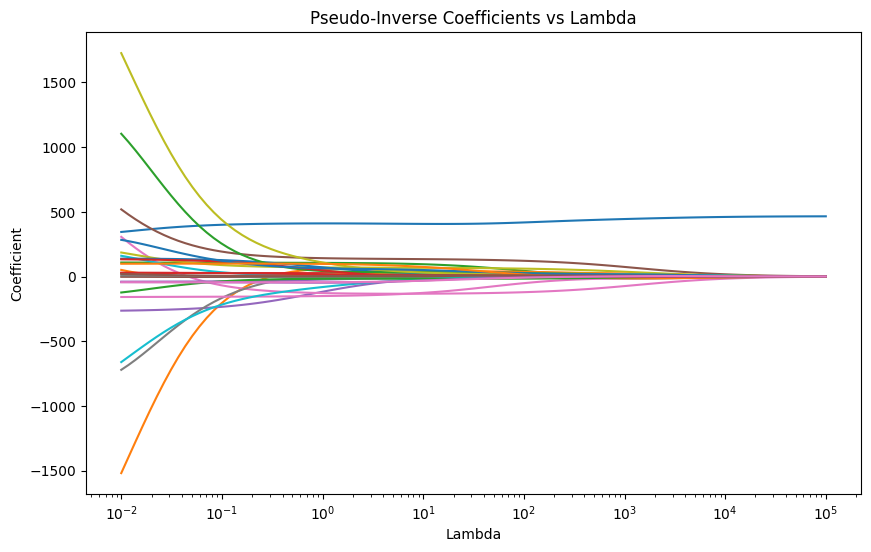

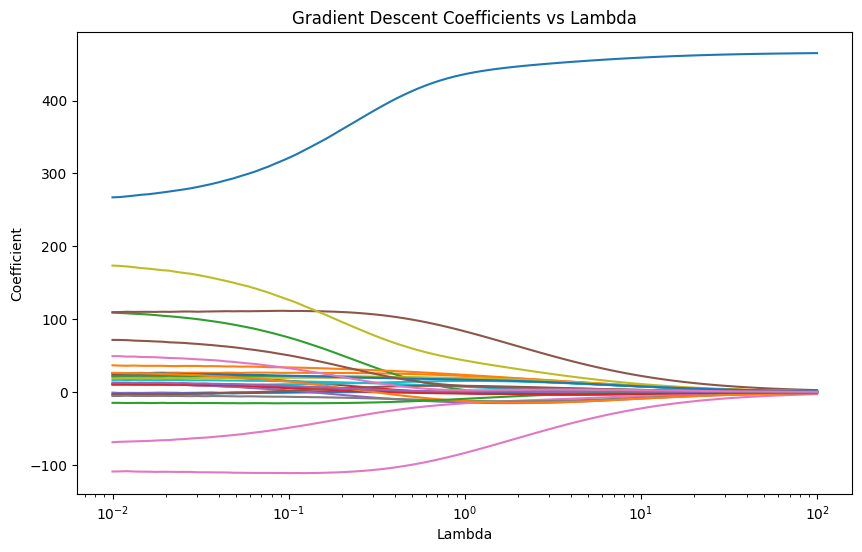

In [265]:
lambdas_pinv = np.logspace(-2, 5, 100)
coefficients_pinv = []

for l in lambdas_pinv:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.pinv_fit()
    coef_with_intercept = np.concatenate(([model.intercept_], model.coef_))
    coefficients_pinv.append(coef_with_intercept)

coefficients_pinv = np.array(coefficients_pinv)

features = X_train_FE.columns
features_with_intercept = ['Intercept'] + list(features)

plt.figure(figsize=(10, 6))
for i in range(coefficients_pinv.shape[1]):
    plt.plot(lambdas_pinv, coefficients_pinv[:, i], label=features_with_intercept[i])

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.title('Pseudo-Inverse Coefficients vs Lambda')
plt.show()


lambdas_gd = np.logspace(-2, 2, 100)
coefficients_gd = []

for l in lambdas_gd:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.gradient_descent_fit()
    coef_with_intercept = np.concatenate(([model.intercept_], model.coef_))
    coefficients_gd.append(coef_with_intercept)

coefficients_gd = np.array(coefficients_gd)

plt.figure(figsize=(10, 6))
for i in range(coefficients_gd.shape[1]):
    plt.plot(lambdas_gd, coefficients_gd[:, i], label=features_with_intercept[i])

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.title('Gradient Descent Coefficients vs Lambda')
plt.show()

## 5.3 - Comparación entre regularización L1 (Lasso) y L2 (Ridge)

En esta sección analizamos el efecto de la regularización L1 sobre los coeficientes del modelo. A diferencia de la regularización L2, que tiende a reducir los coeficientes pero mantenerlos pequeños y distribuidos, L1 favorece soluciones más esparsas, es decir, con muchos coeficientes exactamente en cero.

Para visualizar este comportamiento, se entrenaron múltiples modelos usando descenso por gradiente, variando el parámetro de regularización $\lambda$ (de $10^{-2}$ a $10^3$) y registrando los valores de los coeficientes para cada modelo.

### Observaciones del gráfico:

- Para valores bajos de $\lambda$, la mayoría de los coeficientes mantienen valores similares a los de una regresión sin regularización.
- A medida que $\lambda$ aumenta, los coeficientes comienzan a decrecer y algunos se vuelven exactamente cero, lo que evidencia el comportamiento de selección de variables propio del Lasso.
- A diferencia de la L2, donde todos los coeficientes tienden suavemente a cero, en la L1 algunos caen abruptamente a cero mientras otros se mantienen, lo que indica que L1 elimina features irrelevantes del modelo.
- En el extremo derecho del gráfico, con valores de $\lambda$ muy grandes, los coeficientes se agrupan en torno a cero, pero con ligeras fluctuaciones.

### Ruido numérico en el extremo derecho:

- Las pequeñas oscilaciones que se observan cuando $\lambda \gg 10^2$ son atribuibles a ruido numérico.
- Esto se debe a que, en ese rango, la penalización domina completamente la función de pérdida y los gradientes se vuelven extremadamente pequeños, lo cual puede generar imprecisiones por redondeo o límites de tolerancia en el optimizador.
- Aunque los coeficientes deberían estar exactamente en cero en teoría, en la práctica permanecen en torno a valores muy pequeños, con ligeras variaciones residuales.

### Comportamiento del término independiente (bias):

- Puede observarse que el bias (término independiente) no se reduce a cero, incluso para valores altos de $\lambda$.
- Esto es esperable, ya que el término independiente no está sujeto a penalización L1 y tiende a aproximar la media de la variable target (precio).
- En este caso, el bias actúa como un valor base de predicción cuando todas las variables explicativas han sido descartadas por la regularización.

### Conclusión:

Este experimento permite observar claramente las diferencias entre L1 y L2:

- **L1 (Lasso)** es útil para realizar selección de variables automáticamente, lo cual es valioso en contextos con muchas features.
- **L2 (Ridge)** es más estable numéricamente y útil cuando se busca mantener todas las variables con pesos reducidos.

Ambas técnicas aportan regularización y ayudan a mitigar el sobreajuste, pero con efectos distintos sobre la estructura del modelo.

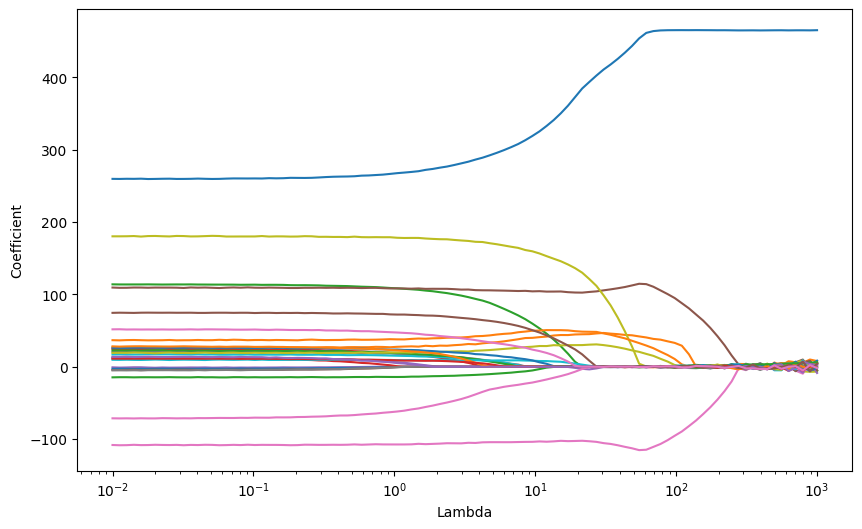

In [266]:
lambdas_gd = np.logspace(-2, 3, 100)
coefficients = []

for l in lambdas_gd:
    model = LinearRegression(X_train_FE, y_train_FE, L1=l)
    model.gradient_descent_fit()
    coef_with_intercept = np.concatenate(([model.intercept_], model.coef_))
    coefficients.append(coef_with_intercept)

coefficients = np.array(coefficients)

plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(lambdas_gd, coefficients[:, i], label=features_with_intercept[i])

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.show()

## 5.4 - Barrido del hiperparámetro $\lambda$: L2 vs L1

Para evaluar el impacto de la regularización y encontrar el valor óptimo del parámetro $\lambda$, realizamos un barrido logarítmico de valores posibles y analizamos el error cuadrático medio (MSE) obtenido sobre el conjunto de validación. Se trabajó con tres configuraciones: L2 con pseudo-inversa, L2 con gradiente descendente, y L1 con gradiente descendente.

### Regularización L2 (pseudo-inversa)

Se evaluó una grilla de $\lambda$ entre $10^{-5}$ y $10^{0}$, ajustando el modelo mediante pseudo-inversa.

El gráfico correspondiente muestra una clara forma de U en la curva de MSE.

A medida que $\lambda$ aumenta desde valores pequeños:

- Inicialmente se observa una mejora (reducción de MSE), indicando que el modelo se vuelve más robusto.
- Luego, el error empieza a subir nuevamente, producto de un exceso de regularización que limita la capacidad del modelo.
- Se identificó un mínimo claro en la curva, que corresponde al valor óptimo de $\lambda$.

Este comportamiento es esperado y deseable: la regularización L2 ayuda a reducir el sobreajuste, pero si se aplica en exceso, conduce al subajuste.

### Regularización L2 (gradiente descendente)

En este caso se entrenó el modelo con descenso por gradiente en una grilla mucho más amplia: $\lambda \in [10^{-30}, 10^{-1}]$.

El gráfico obtenido no muestra una forma de U clara.

- La curva de MSE se mantiene prácticamente constante para valores muy bajos de $\lambda$, lo que sugiere que el modelo no se ve afectado por la penalización en ese rango.
- A partir de cierto punto, el MSE empieza a aumentar bruscamente, lo que indica que el modelo comienza a subajustarse por exceso de regularización.
- El valor mínimo de MSE se encuentra en un $\lambda$ muy pequeño ($< 10^{-10}$), lo que indica que para este optimizador y esta tarea, la regularización L2 no genera mejoras significativas a menos que sea muy débil. El comportamiento plano en la parte izquierda es atribuible a la tolerancia numérica del optimizador.

### Regularización L1 (gradiente descendente)

Finalmente, se realizó el mismo procedimiento con L1, también utilizando gradiente descendente y una grilla entre $10^{-30}$ y $10^{0}$.

- La curva de MSE es mucho más ruidosa y no muestra una tendencia clara.
- El mínimo se encuentra en un punto muy cercano a $10^{-4}$, pero con un comportamiento irregular alrededor.
- La parte baja de la curva es relativamente plana, lo que sugiere que los cambios en $\lambda$ no están afectando significativamente el error en ese rango.
- Al igual que en L2 con gradiente, el MSE aumenta rápidamente cuando $\lambda$ es demasiado alto, al eliminar variables relevantes.

Este resultado refuerza la idea de que L1 introduce mayor inestabilidad numérica y sugiere que su desempeño depende más de una selección cuidadosa de $\lambda$.

### Conclusión

En el caso de L2 con pseudo-inversa, el barrido de $\lambda$ permitió encontrar un valor óptimo claro que mejora el rendimiento en validación.

En cambio, con descenso por gradiente, tanto L2 como L1 presentaron comportamientos más planos o inestables, sin una ganancia clara a partir de la regularización.

Esto puede deberse a limitaciones numéricas, la escala de regularización evaluada, o a que el modelo ya tiene buena capacidad de generalización gracias a la ingeniería de features.

Este análisis confirma que el valor óptimo de $\lambda$ depende tanto del método de entrenamiento como del tipo de regularización, y que su elección debe hacerse de forma empírica mediante validación.

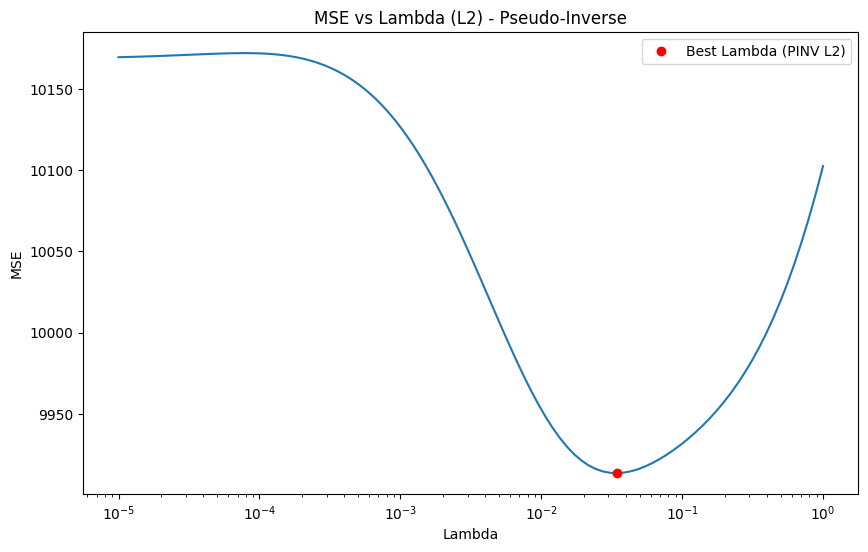

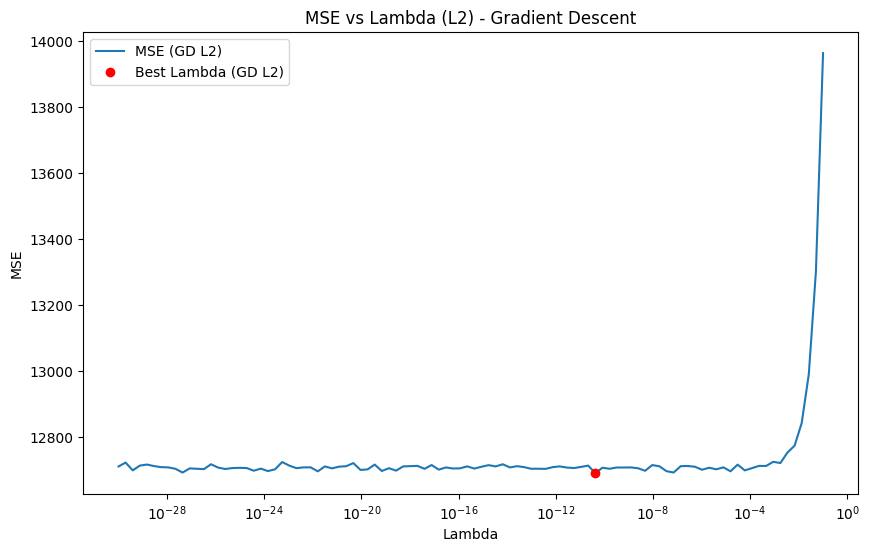

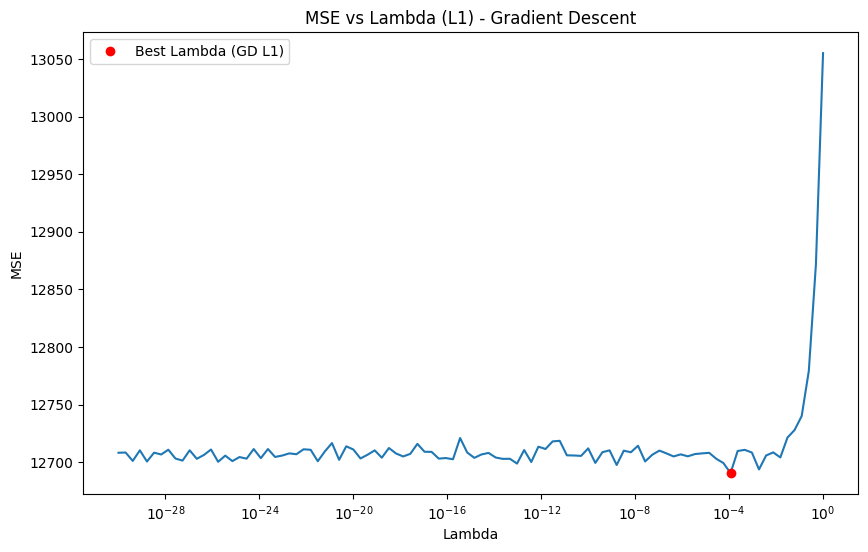

In [276]:
lambdas = np.logspace(-5, 0, 100)
mse_values_pinv = []

for l in lambdas:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.pinv_fit()
    mse_values_pinv.append(model.loss(X_validate_FE, y_validate_FE, mse))


best_lambda = lambdas[np.argmin(mse_values_pinv)]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_values_pinv)
plt.plot(best_lambda, np.min(mse_values_pinv), 'ro', label='Best Lambda (PINV L2)')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda (L2) - Pseudo-Inverse')
plt.legend()
plt.show()


lambdas = np.logspace(-30, -1, 100)
mse_values_gd_l2 = []

for l in lambdas:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.gradient_descent_fit()
    mse_values_gd_l2.append(model.loss(X_validate_FE, y_validate_FE, mse))

best_lambda_gd_l2 = lambdas[np.argmin(mse_values_gd_l2)]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_values_gd_l2, label='MSE (GD L2)')
plt.plot(best_lambda_gd_l2, np.min(mse_values_gd_l2), 'ro', label='Best Lambda (GD L2)')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda (L2) - Gradient Descent')
plt.legend()
plt.show()


lambdas = np.logspace(-30, 0, 100)
mse_values_gd_l1 = []

for l in lambdas:
    model = LinearRegression(X_train_FE, y_train_FE, L1=l)
    model.gradient_descent_fit()
    mse_values_gd_l1.append(model.loss(X_validate_FE, y_validate_FE, mse))

best_lambda = lambdas[np.argmin(mse_values_gd_l1)]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_values_gd_l1)
plt.plot(best_lambda, np.min(mse_values_gd_l1), 'ro', label='Best Lambda (GD L1)')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda (L1) - Gradient Descent')
plt.legend()
plt.show()



## 5.6 - Selección del mejor $\lambda$ mediante validación cruzada

Para obtener un valor óptimo de regularización $\lambda$ que garantice buena generalización, se utilizó el método de validación cruzada (k-fold cross validation).

Este método consiste en dividir el conjunto de entrenamiento en $k$ particiones (folds). Luego, el modelo se entrena $k$ veces, usando $k-1$ folds para entrenamiento y 1 para validación. Se calcula el error promedio de estas validaciones, y se repite este proceso para cada valor de $\lambda$ en una grilla logarítmica.

### Regularización L2 - Pseudo-inversa

Se utilizó una grilla de $\lambda \in [10^{-5}, 10^{-1}]$.

En cada iteración, el modelo fue ajustado con pseudo-inversa y evaluado sobre los folds de validación.

El gráfico resultante muestra el MSE promedio para cada $\lambda$.

Se observa una curva en U, con un mínimo claro que permite identificar el mejor $\lambda$.

El modelo entrenado con este valor óptimo se evaluó luego en el conjunto de validación final, obteniendo los siguientes resultados:

- **MSE PINV**: 10076.22
- **MAE PINV**: 73.28
- **R2 PINV**: 0.9114

### Regularización L2 - Gradiente descendente

Se usó una grilla de $\lambda \in [10^{-3}, 10^{-1}]$.

En este caso, el entrenamiento se hizo por descenso por gradiente, con los mismos folds.

La curva de MSE resultante muestra nuevamente una zona de mínimo, aunque más plana y ruidosa que en el caso anterior.

A pesar de eso, se pudo determinar un valor de $\lambda$ que minimiza el error medio.

Con este valor, se reentrenó el modelo completo y se evaluó su rendimiento en validación:

- **MSE GD**: 12863.56
- **MAE GD**: 80.94
- **R2 GD**: 0.8869

### Conclusión

La validación cruzada permite una selección robusta del hiperparámetro $\lambda$, minimizando la dependencia del conjunto de validación. En este caso, el modelo entrenado con pseudo-inversa y regularización L2 obtuvo mejores métricas en validación que su contraparte entrenada con gradiente descendente, destacándose principalmente en menor error absoluto medio (MAE) y mayor poder explicativo (R²).

Esto sugiere que, para esta tarea y conjunto de datos, la combinación de pseudo-inversa con regularización L2 fue la opción más efectiva.

c:\Users\iluno\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


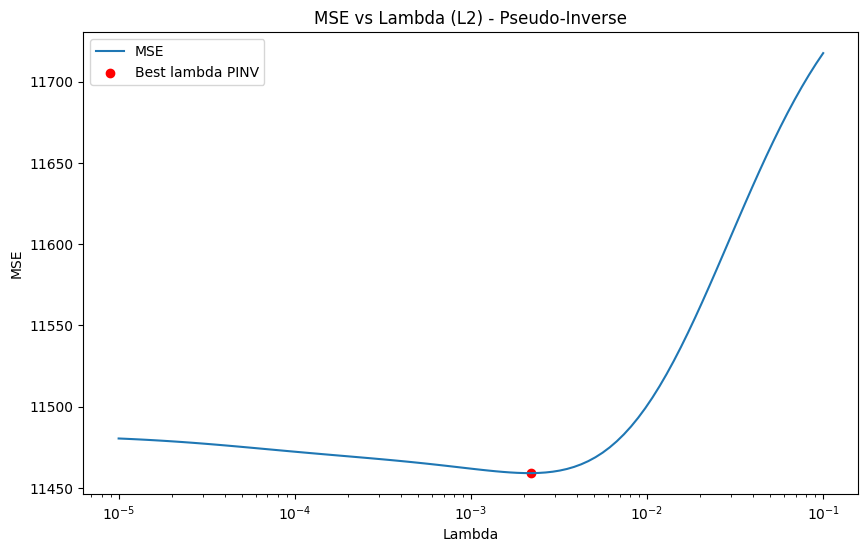

Best lambda: 0.0022051307399030455
**Trained using pinv method**


|   Intercept |     area |   is_house |   has_pool |      age |     lat |     lon |    rooms |   area_units_sqft |   m2_per_room |   age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |   is_new |   is_big |   is_near_center |
|------------:|---------:|-----------:|-----------:|---------:|--------:|--------:|---------:|------------------:|--------------:|--------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|---------:|---------:|-----------------:|
|      347.74 | -2469.98 |    109.087 |    26.4528 | -267.663 | 953.544 | 731.797 | -861.318 |           166.749 |       218.645 | 137.386 |    215.303 |     1413.85 |   135.555 |                -40.0933 |                -1.45026 |                     -159.936 |                    10.4749 |   2638.5 | -969.256 |   309.199 |                97.7626 |       -157.832 |            31.0193 |  -42.594 |  30.6511 |         -44.0888 |

MSE PINV: 10076.218966452541
MAE PINV: 73.28374074732979
R2 PINV: 0.9114324479187155


c:\Users\iluno\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


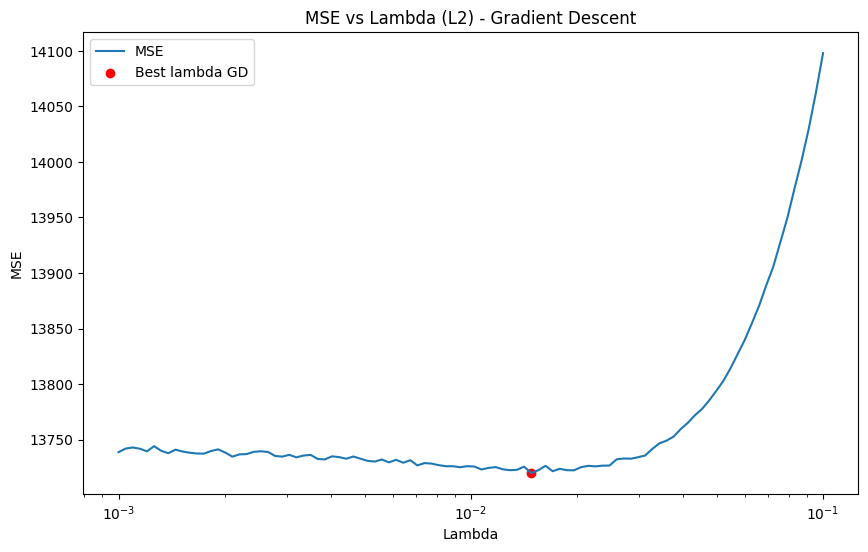

Best lambda: 0.01484968262254465
**Trained using gradient_descent method**


|   Intercept |    area |   is_house |   has_pool |      age |     lat |      lon |   rooms |   area_units_sqft |   m2_per_room |   age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |   is_new |   is_big |   is_near_center |
|------------:|--------:|-----------:|-----------:|---------:|--------:|---------:|--------:|------------------:|--------------:|--------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|---------:|---------:|-----------------:|
|     270.387 | 26.6456 |    106.957 |    22.8413 | -0.53589 | 109.896 | -109.003 | 20.9622 |           170.574 |       16.7455 | -2.6868 |    36.0669 |      22.174 |   10.3758 |                 11.0881 |                -3.26208 |                     -67.2357 |                   -4.83925 |  19.6227 |  9.46464 |   25.6314 |                25.5267 |       -14.6665 |            10.6866 |  12.6849 |  70.5116 |           48.502 |

MSE GD: 12863.560588899762
MAE GD: 80.93688887408403
R2 GD: 0.8869323824540465


In [279]:
lambdas = np.logspace(-5, -1, 100)

best_lambda_pinv, errors = cross_validate(df, lambdas=lambdas, L2=True)

plt.figure(figsize=(10, 6))
plt.plot(lambdas, errors, label='MSE')
plt.scatter(best_lambda_pinv, min(errors), color='red', label='Best lambda PINV')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda (L2) - Pseudo-Inverse')
plt.legend()
plt.show()

print("Best lambda:", best_lambda_pinv)

model = LinearRegression(X_train_FE, y_train_FE, L2=best_lambda_pinv)
model.pinv_fit()
model.print_model()

mse_pinv = model.loss(X_validate_FE, y_validate_FE, mse)
mae_pinv = model.loss(X_validate_FE, y_validate_FE, mae)
r2_pinv = model.loss(X_validate_FE, y_validate_FE, r2)

print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)

lambda_gd = np.logspace(-3, -1, 100)

best_lambda_gd, errors_gd = cross_validate(df, lambdas=lambda_gd, L2=True, training_method='gradient_descent')

plt.figure(figsize=(10, 6))
plt.plot(lambda_gd, errors_gd, label='MSE')
plt.scatter(best_lambda_gd, min(errors_gd), color='red', label='Best lambda GD')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda (L2) - Gradient Descent')
plt.legend()
plt.show()

print("Best lambda:", best_lambda_gd)

model = LinearRegression(X_train_FE, y_train_FE, L2=best_lambda_gd)
model.gradient_descent_fit()
model.print_model()

mse_gd = model.loss(X_validate_FE, y_validate_FE, mse)
mae_gd = model.loss(X_validate_FE, y_validate_FE, mae)
r2_gd = model.loss(X_validate_FE, y_validate_FE, r2)

print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd)


## 6.1 - Selección del modelo final

Se eligió como modelo final la regresión lineal con pseudo-inversa utilizando regularización L2 (Ridge).

El valor óptimo de $\lambda$ se obtuvo mediante validación cruzada.

La decisión se basó en que este modelo logró:

- El menor error cuadrático medio (MSE).
- El menor error absoluto medio (MAE).
- El mayor coeficiente de determinación (R²).

En validación, los resultados obtenidos fueron:

- **MSE**: 10076.22
- **MAE**: 73.28
- **R²**: 0.9114

Este rendimiento fue superior al de modelos entrenados con gradiente descendente y otras formas de regularización.

## 6.2 - Evaluación sobre el conjunto de test

Se aplicó el modelo final sobre el conjunto de test, que se mantuvo completamente separado durante el proceso de entrenamiento y validación.

El procesamiento de los datos de test fue idéntico al del entrenamiento:

- Imputación de valores faltantes (`age`, `rooms`).
- Codificación one-hot para `area_units`.
- Conversión de `area_units_sqft` a m².
- Aplicación de feature engineering.
- Normalización utilizando las estadísticas obtenidas del conjunto de entrenamiento (`stats_dict_train_FE`).

Se evaluó el rendimiento del modelo con regularización L2 (pseudo-inversa) sobre los datos de test.

Estos resultados confirman que el modelo generaliza correctamente y mantiene un alto poder predictivo en datos no vistos, sin evidencia de sobreajuste.

In [ ]:
model = LinearRegression(X_train_FE, y_train_FE, L2=best_lambda_pinv)
model.pinv_fit()

df_test = pd.read_csv(os.path.join(cwd, '..', 'data', 'raw', 'casas_test.csv'))

handle_missing_values(df_test, "age")
handle_missing_values(df_test, "rooms")

df_test = one_hot_encoding(df_test, "area_units")
convert_sqft_to_m2(df_test, "area_units_sqft", "area")

df_test = feature_engineer(df_test)

df_test_normalized, _ = normalize_df(df_test, train=False, stats=stats_dict_train_FE)

features = df_train_nomarlized_FE.columns.drop(TARGET)

X_test = df_test_normalized[features]
y_test = df_test_normalized[TARGET]

mse_test = model.loss(X_test, y_test, mse)
mae_test = model.loss(X_test, y_test, mae)
rmse_test = model.loss(X_test, y_test, rmse)
r2_test = model.loss(X_test, y_test, r2)

print("MSE test:", mse_test)
print("MAE test:", mae_test)
print("RMSE test:", rmse_test)
print("R2 test:", r2_test)

MSE test: 9281.845413300109
MAE test: 73.49833923935749
RMSE test: 96.34233448126587
R2 test: 0.9013484644567913
